### libraries

In [3]:
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
from scipy.stats import bernoulli, binom
import seaborn as sns
from scipy import stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes
from matplotlib.lines import Line2D
from imblearn.combine import SMOTEENN

In [4]:
# Import libraries for LR
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [5]:
from sklearn import tree          
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics
# Import libraries 
from sklearn import tree          
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
# Import libraries
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import graphviz  

In [6]:
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [7]:
from xgboost import XGBClassifier

# Helper functions for model training

In [8]:
# function that returns dataset with propensity scores and propensity logits from logistic regression
def propensity_score_funct(dataset,model):
    # Generate propensity score prediction 
    probabilities = model.predict_proba(dataset.drop('treat', axis=1))
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1] # propensity score 
    # merge prediction and existing dataset 
    dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    
    #dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    dataset_proba['propensity_logit'] = pd.DataFrame(np.nan_to_num(np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score'])),posinf=0,neginf=0))
    


In [9]:
resample=SMOTEENN(random_state=0)
# KFold cross validation 
def kfold_evaluation_SMOTEENN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
	
	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
		#resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 

# 1 - Load data sets 

In [10]:
'''
Load all datasets.
nsw = Male sub sample of treated and control units as used by Lalonde (1986).
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)

cps1 = full Current Population Survey dataset
cps2 , cps3 and cps4 are further subsamples exctracted by lalonde to with distributions which better match the nsw treated group.

psid1 = full Panel Study of Income Dynamics dataset
psid2,psid3,psid4 are again subsamples extracted by Lalonde 

'''
# experimental data 

nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)
nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/nswre74_treated.xlsx')
nswre74 = pd.concat([nswre74_control,nswre74_treated],axis=0,ignore_index=True) #Combine treatment into a single control as pandas dataframe

# non experimental data (cps)

cps = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/cps_controls.dta")
cps.drop('data_id', axis=1, inplace=True)

#cps['treat'] == 0 # created treated column
#load non experimental data (psid)

psid = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/psid_controls.dta")
psid.drop('data_id', axis=1, inplace=True)

# reset indexes

nsw = nsw.reset_index(drop=True)
nswre74 = nswre74.reset_index(drop=True)
cps = cps.reset_index(drop=True)
psid = psid.reset_index(drop=True)

# PS estimation helper functions

In [11]:
def propensity_score_funct(dataset,model,dataset2,dehwab):
    
    dataset2.columns = dataset2.columns.str.strip() 
    
    if dehwab == True: 
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re74','re75','re78']]
    else:
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re75','re78']]

    treat =  dataset.iloc[:,0]
    dataset =  dataset.iloc[:,1:len(dataset)]

    probabilities = model.predict_proba(dataset)
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1]  # propensity score 

    dataset_proba = pd.merge(dataset2, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [12]:
resample=SMOTEENN(random_state=0)
# KFold cross validation 
def kfold_evaluation_SMOTEENN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
	

	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		X_train, y_train = resample.fit_resample(X_train, y_train)	
		#shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1,random_state=42)
		#resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 

# 2. Propensity score estimation

In [13]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

### PS specs

In [14]:
ps_specification_logit_1 = ['treat','education*','black','hispanic','married','married_u75','nodegree','re75']
ps_specification_logit_2 = ['treat','age','education*','black','married','hispanic','black_education','hisp_re75','nodegree','re75']
ps_specification_logit_3 = ['treat','age','education*','black','hispanic','nodegree','black_age','married','re74','re75']
ps_specification_logit_4 = ['treat','age','education*','black','married','hispanic','married_u75','nodegree','re74','re75']



In [17]:
#['treat','age','education*','black','married','nodegree','re75'] # CPS Lalonde sample 
markov_blanket_specification_1 = ['treat','age','black','education*','married','nodegree','re75'] # CPS Lalonde sample 
markov_blanket_specification_2 = ['treat','age','education*','married','nodegree','re75']  # PSID Lalonde sample 
markov_blanket_specification_3 = ['treat','age','black','education*','married','nodegree','re74','re75'] # CPS Dehwab sample
markov_blanket_specification_4 = ['treat','age','education*','married','nodegree','re74','re75'] # PSID Dehwab and wahba sample 

In [6]:
annSpecification_1 = ['treat','ageboxcox','education*','black','married','nodegree','re75'] # CPS Lalonde sample 
annSpecification_2 = ['treat','ageboxcox','education*','married','nodegree','re75']# PSID Lalonde sample  
annSpecification_3 = ['treat','ageboxcox','education*','black','married','re74','re75'] # CPS Dehwab sample
annSpecification_4 = ['treat','ageboxcox','education*','married','nodegree','re74','re75'] # PSID Dehwab and wahba sample 
nsw_continuos_vars1 = ['ageboxcox','re75'] 
nsw_continuos_vars2 = ['ageboxcox','re75'] 
nswre74_continuos_vars1 = ['ageboxcox','re75',] 
nswre74_continuos_vars2 = ['ageboxcox','re74','re75',] 

### model (1) Logistic Regression 

### Data

In [19]:
# Select covariates for use in Logit model 

# ======== Lalonde (1986) data ======== #

nswCps_lalonde_subset = nswCps_lalonde[ps_specification_logit_1]
nswPsid_lalonde_subset = nswPsid_lalonde[ps_specification_logit_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

nswCps_dehWab_subset = nswCps_dehWab[ps_specification_logit_3]
nswPsid_dehWab_subset = nswPsid_dehWab[ps_specification_logit_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

### Validation

In [20]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

# KFold cross validation 
def kfold_evaluation(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		predicted_proba = model.predict_proba(X_test)
		prediction_proba_df = pd.DataFrame(predicted_proba)
		pos_predicted_proba = prediction_proba_df[1] # Take positive probability predictions for ROC_AUC score  
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, pos_predicted_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, predicted_proba)
		

	#Kfold training loop
	
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 


In [21]:
from sklearn.linear_model import LogisticRegression
# dataframes to store resutls 
logit1_metrics = pd.DataFrame()
logit2_metrics = pd.DataFrame()
logit3_metrics = pd.DataFrame()
logit4_metrics = pd.DataFrame()
#models 
logit1 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit2 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit3 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit4 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)


In [22]:
# Model validation - K fold 
# ======== Lalonde (1986) sample ======== #
kfold_evaluation(logit1,nswCps_lalonde_features,nswCps_lalonde_target,logit1_metrics) # cps
kfold_evaluation(logit2,nswPsid_lalonde_features,nswPsid_lalonde_target,logit2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation(logit3,nswCps_dehWab_features,nswCps_dehWab_target,logit3_metrics) # cps
kfold_evaluation(logit4,nswPsid_dehWab_features,nswPsid_dehWab_target,logit4_metrics) # psid

In [23]:
logit1_metrics['avg'] = np.mean(logit1_metrics,axis=1)
logit2_metrics['avg'] = np.mean(logit2_metrics,axis=1)
logit3_metrics['avg'] = np.mean(logit3_metrics,axis=1)
logit4_metrics['avg'] = np.mean(logit4_metrics,axis=1)

In [24]:
logit1_metrics

,0,1,2,3,4,avg
Accuracy:,0.888868,0.864759,0.861991,0.900891,0.892650,0.881832
Precision:,0.121348,0.130890,0.112360,0.129496,0.096552,0.118129
Recall:,0.900000,0.833333,0.847458,0.915254,0.949153,0.889040
MSE:,0.121854,0.104972,0.124002,0.112953,0.161805,0.125117
MAE:,0.121854,0.104972,0.124002,0.112953,0.161805,0.125117
R^2:,-5.740807,-4.806942,-5.973747,-5.352324,-8.096994,-5.994163
auc:,0.888868,0.864759,0.861991,0.900891,0.892650,0.881832
roc_auc:,0.962044,0.947871,0.945158,0.959619,0.964756,0.955889
F1:,0.213861,0.226244,0.198413,0.226891,0.175274,0.208137
log-loss:,0.263571,0.241323,0.262708,0.270125,0.337827,0.275111


In [25]:
logit1.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [26]:
logit2_metrics

,0,1,2,3,4,avg
Accuracy:,0.869779,0.913855,0.862603,0.904976,0.917790,0.893801
Precision:,0.481132,0.600000,0.521739,0.546392,0.467213,0.523295
Recall:,0.850000,0.900000,0.813559,0.898305,0.966102,0.885593
MSE:,0.114695,0.075269,0.098743,0.089767,0.120287,0.099752
MAE:,0.114695,0.075269,0.098743,0.089767,0.120287,0.099752
R^2:,-0.195181,0.215663,-0.042645,0.052141,-0.270131,-0.048031
auc:,0.869779,0.913855,0.862603,0.904976,0.917790,0.893801
roc_auc:,0.960793,0.972122,0.951603,0.972262,0.974032,0.966162
F1:,0.614458,0.720000,0.635762,0.679487,0.629834,0.655908
log-loss:,0.250577,0.200025,0.241414,0.204177,0.283941,0.236027


In [27]:
logit2.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [28]:
logit3_metrics

,0,1,2,3,4,avg
Accuracy:,0.879603,0.878040,0.875767,0.893413,0.936143,0.892593
Precision:,0.086486,0.084211,0.100977,0.089431,0.100559,0.092333
Recall:,0.864865,0.864865,0.837838,0.891892,0.972973,0.886486
MSE:,0.105995,0.109085,0.087172,0.105100,0.099845,0.101440
MAE:,0.105995,0.109085,0.087172,0.105100,0.099845,0.101440
R^2:,-8.377491,-8.650888,-6.709802,-8.295506,-7.830730,-7.972883
auc:,0.879603,0.878040,0.875767,0.893413,0.936143,0.892593
roc_auc:,0.961863,0.948616,0.969677,0.953949,0.983055,0.963432
F1:,0.157248,0.153477,0.180233,0.162562,0.182278,0.167160
log-loss:,0.233103,0.260611,0.213819,0.247897,0.239693,0.239025


In [29]:
logit3.get_params

<bound method BaseEstimator.get_params of LogisticRegression(class_weight='balanced', max_iter=500, penalty='none',
                   random_state=0)>

In [30]:
logit4_metrics

,0,1,2,3,4,avg
Accuracy:,0.942310,0.897292,0.957831,0.885244,0.957831,0.928102
Precision:,0.450000,0.477612,0.468354,0.405063,0.468354,0.453877
Recall:,0.972973,0.864865,1.000000,0.864865,1.000000,0.940541
MSE:,0.084112,0.074766,0.078505,0.097196,0.078505,0.082617
MAE:,0.084112,0.074766,0.078505,0.097196,0.078505,0.082617
R^2:,-0.306578,-0.161402,-0.219472,-0.509823,-0.219472,-0.283350
auc:,0.942310,0.897292,0.957831,0.885244,0.957831,0.928102
roc_auc:,0.983122,0.962254,0.982036,0.949256,0.986215,0.972577
F1:,0.615385,0.615385,0.637931,0.551724,0.637931,0.611671
log-loss:,0.192810,0.177873,0.200565,0.260109,0.206918,0.207655


In [31]:
logit4.get_params()

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

### Inference

In [32]:
# Fit Logistic Regression using sklearn
# ======== Lalonde (1986) sample ======== #
logit1.fit(nswCps_lalonde_features,nswCps_lalonde_target) # cps
logit2.fit(nswPsid_lalonde_features,nswPsid_lalonde_target) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
logit3.fit(nswCps_dehWab_features,nswCps_dehWab_target) # cps
logit4.fit(nswPsid_dehWab_features,nswPsid_dehWab_target) # psid

LogisticRegression(class_weight='balanced', max_iter=500, penalty='none',
                   random_state=0)

In [33]:
# Change logisistic regression to STAT's model implementation 

In [34]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
nswCps_lalonde_ps_LOGIT_withRe78 = propensity_score_funct(nswCps_lalonde_subset,logit1,nswCps_lalonde,False)
nswPsid_lalonde_ps_LOGIT_withRe78= propensity_score_funct(nswPsid_lalonde_subset,logit2,nswPsid_lalonde,False)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_LOGIT_withRe78 = propensity_score_funct(nswCps_dehWab_subset,logit3,nswCps_dehWab,True)
nswPsid_dehWab_ps_LOGIT_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,logit4,nswPsid_dehWab,True)


# Export data

In [35]:
# save unmatched logit datasets 
nswCps_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswCps_lalonde_ps_unmatched_LOGIT_FS1.csv')
nswPsid_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswPsid_lalonde_ps_unmatched_LOGIT_FS1.csv')
nswCps_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswCps_dehWab_ps_unmatched_LOGIT_FS1.csv')
nswPsid_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/logit/unmatched/nswPsid_dehWab_ps_unmatched_LOGIT_FS1.csv')

### model (2) ; CART 

In [36]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling

nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

# CART - Feature selection

In [37]:
""" Select covariates for use in CART model - from GNN features """
# ======== Lalonde (1986) data ======== #
nswCps_lalonde_subset = nswCps_lalonde[markov_blanket_specification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[markov_blanket_specification_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

# Apply selection

nswCps_dehWab_subset = nswCps_dehWab[markov_blanket_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[markov_blanket_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)


## Validation 

In [38]:
# Grid search 
tree_param = [{'criterion': ['entropy', 'gini'], 
               'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
               'max_leaf_nodes':list(range(0, 100)),
              'min_samples_leaf': [2, 3, 4]}]



In [39]:
cart1_metrics = pd.DataFrame()
cart2_metrics = pd.DataFrame()
cart3_metrics = pd.DataFrame()
cart4_metrics = pd.DataFrame()

grid_search_cart1 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5,max_leaf_nodes = 12,min_samples_leaf = 2)
grid_search_cart2 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 7,max_leaf_nodes = 10,min_samples_leaf = 2)
grid_search_cart3 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5,max_leaf_nodes = 10,min_samples_leaf = 2)
grid_search_cart4 = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5,max_leaf_nodes = 10,min_samples_leaf = 2)

In [40]:
kfold_evaluation_SMOTEENN(grid_search_cart1,nswCps_lalonde_features,nswCps_lalonde_target,cart1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart2,nswPsid_lalonde_features,nswPsid_lalonde_target,cart2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_cart3,nswCps_dehWab_features,nswCps_dehWab_target,cart3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart4,nswPsid_dehWab_features,nswPsid_dehWab_target,cart4_metrics) # psid

<p> model evaluation </p>

In [41]:
cart1_metrics['avg'] = np.mean(cart1_metrics,axis=1)
cart2_metrics['avg'] = np.mean(cart2_metrics,axis=1)
cart3_metrics['avg'] = np.mean(cart3_metrics,axis=1)
cart4_metrics['avg'] = np.mean(cart4_metrics,axis=1)

In [42]:
cart1_metrics

,0,1,2,3,4,avg
Accuracy:,0.828377,0.844575,0.811093,0.855063,0.861876,0.840197
Precision:,0.325397,0.328244,0.351852,0.278481,0.167857,0.290366
Recall:,0.683333,0.716667,0.644068,0.745763,0.796610,0.717288
MSE:,0.031921,0.032228,0.027931,0.039595,0.075223,0.041380
MAE:,0.031921,0.032228,0.027931,0.039595,0.075223,0.041380
R^2:,-0.765854,-0.782833,-0.570819,-1.226766,-3.229153,-1.315085
auc:,0.828377,0.844575,0.811093,0.855063,0.861876,0.840197
roc_auc:,0.912344,0.904073,0.934929,0.952414,0.950856,0.930923
F1:,0.440860,0.450262,0.455090,0.405530,0.277286,0.405806
log-loss:,0.203878,0.153560,0.163919,0.171362,0.270913,0.192726


In [43]:
cart2_metrics

,0,1,2,3,4,avg
Accuracy:,0.826205,0.878916,0.848104,0.916020,0.904414,0.874732
Precision:,0.573333,0.695652,0.484536,0.616279,0.504673,0.574895
Recall:,0.716667,0.800000,0.796610,0.898305,0.915254,0.825367
MSE:,0.087814,0.059140,0.111311,0.070018,0.104129,0.086482
MAE:,0.087814,0.059140,0.111311,0.070018,0.104129,0.086482
R^2:,0.084940,0.383735,-0.175345,0.260670,-0.099517,0.090896
auc:,0.826205,0.878916,0.848104,0.916020,0.904414,0.874732
roc_auc:,0.886044,0.932112,0.918930,0.952709,0.960724,0.930104
F1:,0.637037,0.744186,0.602564,0.731034,0.650602,0.673085
log-loss:,1.055793,0.325228,0.364697,0.233530,0.288515,0.453553


In [44]:
cart3_metrics

,0,1,2,3,4,avg
Accuracy:,0.907040,0.883055,0.891490,0.894305,0.922270,0.899632
Precision:,0.289720,0.173410,0.252101,0.297030,0.329897,0.268431
Recall:,0.837838,0.810811,0.810811,0.810811,0.864865,0.827027
MSE:,0.025340,0.046354,0.029675,0.024111,0.021638,0.029424
MAE:,0.025340,0.046354,0.029675,0.024111,0.021638,0.029424
R^2:,-1.241849,-3.100944,-1.624613,-1.132498,-0.913781,-1.602737
auc:,0.907040,0.883055,0.891490,0.894305,0.922270,0.899632
roc_auc:,0.946613,0.921542,0.908499,0.974351,0.974059,0.945013
F1:,0.430556,0.285714,0.384615,0.434783,0.477612,0.402656
log-loss:,0.107183,0.154493,0.116569,0.138555,0.106300,0.124620


In [45]:
cart4_metrics

,0,1,2,3,4,avg
Accuracy:,0.933355,0.874824,0.941848,0.860767,0.918376,0.905834
Precision:,0.566667,0.630435,0.530303,0.483333,0.695652,0.581278
Recall:,0.918919,0.783784,0.945946,0.783784,0.864865,0.859459
MSE:,0.054206,0.046729,0.061682,0.072897,0.035514,0.054206
MAE:,0.054206,0.046729,0.061682,0.072897,0.035514,0.054206
R^2:,0.157983,0.274124,0.041843,-0.132367,0.448334,0.157983
auc:,0.933355,0.874824,0.941848,0.860767,0.918376,0.905834
roc_auc:,0.976419,0.943721,0.979893,0.886356,0.925594,0.942397
F1:,0.701031,0.698795,0.679612,0.597938,0.771084,0.689692
log-loss:,0.200567,0.563904,0.612808,0.612825,0.417297,0.481480


### Inference

In [46]:
nswCps_lalonde_ps_CART_withRe78 = propensity_score_funct(nswCps_lalonde_subset,grid_search_cart1,nswCps_lalonde,False)
nswPsid_lalonde_ps_CART_withRe78= propensity_score_funct(nswPsid_lalonde_subset,grid_search_cart2,nswPsid_lalonde,False)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_CART_withRe78 = propensity_score_funct(nswCps_dehWab_subset,grid_search_cart3,nswCps_dehWab,True)
nswPsid_dehWab_ps_CART_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,grid_search_cart4,nswPsid_dehWab,True)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [50]:
nswPsid_dehWab_ps_CART_withRe78

,treat,age,education*,black,hispanic,married,nodegree,re74,re75,re78,propensity_score,propensity_logit
0,1.0,37,11,1.0,0.0,1.0,1.0,0,0,9930,0.061947,-2.717529
1,1.0,22,9,0.0,1.0,0.0,1.0,0,0,3595,0.999251,7.196687
2,1.0,30,12,1.0,0.0,0.0,0.0,0,0,24909,0.999251,7.196687
3,1.0,27,11,1.0,0.0,0.0,1.0,0,0,7506,0.999251,7.196687
4,1.0,33,8,1.0,0.0,0.0,1.0,0,0,289,0.999251,7.196687
...,...,...,...,...,...,...,...,...,...,...,...,...
2670,0.0,47,8,0.0,0.0,1.0,1.0,44667,33837,38568,0.004071,-5.499897
2671,0.0,32,8,0.0,0.0,1.0,1.0,47022,67137,59109,0.004071,-5.499897
2672,0.0,47,10,0.0,0.0,1.0,1.0,48197,47968,55710,0.004071,-5.499897
2673,0.0,54,0,0.0,1.0,1.0,1.0,49228,44220,20540,0.004071,-5.499897


In [51]:
# save unmatched CART datasets 
nswCps_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswCps_lalonde_ps_unmatched_CART_FS1.csv')
nswPsid_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswPsid_lalonde_ps_unmatched_CART_FS1.csv')
nswCps_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswCps_dehWab_ps_unmatched_CART_FS1.csv')
nswPsid_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/cart/unmatched/nswPsid_dehWab_ps_unmatched_CART_FS1.csv')

### model (3) ; Random Forest

In [52]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78


In [53]:
""" Select covariates for use in CART model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #

nswCps_lalonde_subset = nswCps_lalonde[markov_blanket_specification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[markov_blanket_specification_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

nswCps_dehWab_subset = nswCps_dehWab[markov_blanket_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[markov_blanket_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

## Validation 

In [54]:
forest1_metrics = pd.DataFrame()
forest2_metrics = pd.DataFrame()
forest3_metrics = pd.DataFrame()
forest4_metrics = pd.DataFrame()

grid_search_forest1 = RandomForestClassifier(random_state=0,criterion = 'entropy',max_depth = 8,max_features = 'sqrt',min_samples_split = 2,n_estimators= 100)
grid_search_forest2 = RandomForestClassifier(random_state=0,criterion = 'gini',max_depth = 8,max_features = 'sqrt',min_samples_split = 2,n_estimators= 100)
grid_search_forest3 = RandomForestClassifier(random_state=0,criterion = 'entropy',max_depth = 8,max_features = 'log2',min_samples_split = 3,n_estimators= 500)
grid_search_forest4 = RandomForestClassifier(random_state=0,criterion = 'gini',max_depth = 8,max_features = 'log2',min_samples_leaf = 2,n_estimators= 500)

In [55]:
kfold_evaluation_SMOTEENN(grid_search_forest1,nswCps_lalonde_features,nswCps_lalonde_target,forest1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest2,nswPsid_lalonde_features,nswPsid_lalonde_target,forest2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_forest3,nswCps_dehWab_features,nswCps_dehWab_target,forest3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest4,nswPsid_dehWab_features,nswPsid_dehWab_target,forest4_metrics) # psid

In [56]:
forest1_metrics['avg'] = np.mean(forest1_metrics,axis=1)
forest2_metrics['avg'] = np.mean(forest2_metrics,axis=1)
forest3_metrics['avg'] = np.mean(forest3_metrics,axis=1)
forest4_metrics['avg'] = np.mean(forest4_metrics,axis=1)

In [57]:
forest1_metrics

,0,1,2,3,4,avg
Accuracy:,0.840353,0.847702,0.821321,0.866039,0.920040,0.859091
Precision:,0.272152,0.387387,0.261438,0.314685,0.282609,0.303654
Recall:,0.716667,0.716667,0.677966,0.762712,0.881356,0.751073
MSE:,0.040516,0.026090,0.040516,0.034377,0.042677,0.036835
MAE:,0.040516,0.026090,0.040516,0.034377,0.042677,0.036835
R^2:,-1.241276,-0.443246,-1.278551,-0.933316,-1.399397,-1.059157
auc:,0.840353,0.847702,0.821321,0.866039,0.920040,0.859091
roc_auc:,0.952116,0.952283,0.933788,0.969426,0.979028,0.957328
F1:,0.394495,0.502924,0.377358,0.445545,0.427984,0.429661
log-loss:,0.108171,0.101750,0.132206,0.112388,0.123123,0.115528


In [58]:
forest2_metrics


,0,1,2,3,4,avg
Accuracy:,0.833233,0.881928,0.867181,0.890154,0.924495,0.879398
Precision:,0.632353,0.727273,0.602564,0.662162,0.620690,0.649008
Recall:,0.716667,0.800000,0.796610,0.830508,0.915254,0.811808
MSE:,0.075269,0.053763,0.077199,0.062837,0.068223,0.067458
MAE:,0.075269,0.053763,0.077199,0.062837,0.068223,0.067458
R^2:,0.215663,0.439759,0.184841,0.336499,0.279627,0.291278
auc:,0.833233,0.881928,0.867181,0.890154,0.924495,0.879398
roc_auc:,0.924916,0.960609,0.930502,0.967820,0.972075,0.951184
F1:,0.671875,0.761905,0.686131,0.736842,0.739726,0.719296
log-loss:,0.394292,0.222957,0.390829,0.185341,0.217657,0.282215


In [59]:
forest3_metrics

,0,1,2,3,4,avg
Accuracy:,0.885640,0.896184,0.859080,0.898995,0.885013,0.884982
Precision:,0.420290,0.337079,0.421875,0.422535,0.397260,0.399808
Recall:,0.783784,0.810811,0.729730,0.810811,0.783784,0.783784
MSE:,0.014833,0.020396,0.014529,0.014838,0.016074,0.016134
MAE:,0.014833,0.020396,0.014529,0.014838,0.016074,0.016134
R^2:,-0.312302,-0.804415,-0.284967,-0.312307,-0.421666,-0.427131
auc:,0.885640,0.896184,0.859080,0.898995,0.885013,0.884982
roc_auc:,0.981240,0.955480,0.986799,0.954816,0.989056,0.973478
F1:,0.547170,0.476190,0.534653,0.555556,0.527273,0.528168
log-loss:,0.054616,0.078579,0.046260,0.064213,0.055769,0.059887


In [60]:
forest4_metrics

,0,1,2,3,4,avg
Accuracy:,0.927874,0.877836,0.946869,0.879301,0.929882,0.912352
Precision:,0.647059,0.674419,0.573770,0.535714,0.673469,0.620886
Recall:,0.891892,0.783784,0.945946,0.810811,0.891892,0.864865
MSE:,0.041121,0.041121,0.052336,0.061682,0.037383,0.046729
MAE:,0.041121,0.041121,0.052336,0.061682,0.037383,0.046729
R^2:,0.361229,0.361229,0.187018,0.041843,0.419299,0.274124
auc:,0.927874,0.877836,0.946869,0.879301,0.929882,0.912352
roc_auc:,0.984099,0.960708,0.988549,0.917128,0.988549,0.967806
F1:,0.750000,0.725000,0.714286,0.645161,0.767442,0.720378
log-loss:,0.103740,0.151643,0.131280,0.355930,0.108682,0.170255


### Inference

In [61]:
#  Lalonde Subsample 
nswCps_lalonde_ps_FOREST_withRe78 = propensity_score_funct(nswCps_lalonde_subset,grid_search_forest1,nswCps_lalonde,False)
nswPsid_lalonde_ps_FOREST_withRe78= propensity_score_funct(nswPsid_lalonde_subset,grid_search_forest2,nswPsid_lalonde,False)
#  Dehejia & Wahba sub sample 
nswCps_dehWab_ps_FOREST_withRe78 = propensity_score_funct(nswCps_dehWab_subset,grid_search_forest3,nswCps_dehWab,True)
nswPsid_dehWab_ps_FOREST_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,grid_search_forest4,nswPsid_dehWab,True)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [64]:
nswCps_dehWab_ps_FOREST_withRe78

,treat,age,education*,black,hispanic,married,nodegree,re74,re75,re78,propensity_score,propensity_logit
0,1.0,37,11,1.0,0.0,1.0,1.0,0,0,9930,0.935999,2.682723
1,1.0,22,9,0.0,1.0,0.0,1.0,0,0,3595,0.351583,-0.612088
2,1.0,30,12,1.0,0.0,0.0,0.0,0,0,24909,0.988211,4.428687
3,1.0,27,11,1.0,0.0,0.0,1.0,0,0,7506,0.996804,5.742562
4,1.0,33,8,1.0,0.0,0.0,1.0,0,0,289,0.996507,5.653493
...,...,...,...,...,...,...,...,...,...,...,...,...
16172,0.0,22,12,1.0,0.0,0.0,0.0,3975,6801,2757,0.624854,0.510203
16173,0.0,20,12,1.0,0.0,1.0,0.0,1445,11832,6895,0.013650,-4.280268
16174,0.0,37,12,0.0,0.0,0.0,0.0,1733,1559,4221,0.029262,-3.501750
16175,0.0,47,9,0.0,0.0,1.0,1.0,16914,11384,13671,0.000000,-inf


In [65]:
# save unmatched logit datasets 
nswCps_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswCps_lalonde_ps_unmatched_FOREST_FS1.csv')
nswPsid_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswPsid_lalonde_ps_unmatched_FOREST_FS1.csv')
nswCps_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswCps_dehWab_ps_unmatched_FOREST_FS1.csv')
nswPsid_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/forest/unmatched/nswPsid_dehWab_ps_unmatched_FOREST_FS1.csv')

### model (4) ; Boosted Trees

In [66]:
""" Select covariates for use in BOOST model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[markov_blanket_specification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[markov_blanket_specification_2]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[markov_blanket_specification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[markov_blanket_specification_4]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)



## Validation 

In [67]:
# dataframes to store results 
boost1_metrics = pd.DataFrame()
boost2_metrics = pd.DataFrame()
boost3_metrics = pd.DataFrame()
boost4_metrics = pd.DataFrame()
    

# models 
grid_search_boost1 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'dart',
                                    colsample_bytree = 0.3,
                                    gamma = 0.5,
                                    learning_rate = 0.05,
                                    max_depth = None,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 
grid_search_boost2 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'dart',
                                    colsample_bytree = 0.3,
                                    gamma = 0.5,
                                    learning_rate = 0.05,
                                    max_depth = None,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 
grid_search_boost3 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'gbtree',
                                    colsample_bytree = 0.3,
                                    gamma = 1,
                                    learning_rate = 0.05,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 
grid_search_boost4 = XGBClassifier(objective= 'binary:logistic',
                                    seed=0,
                                    booster = 'gbtree',
                                    colsample_bytree = 0.3,
                                    gamma = 0.5,
                                    learning_rate = 0.05,
                                    min_child_weight = 2,
                                    subsample = 0.5,
                                    nthread=4) 

In [68]:
kfold_evaluation_SMOTEENN(grid_search_boost1,nswCps_lalonde_features,nswCps_lalonde_target,boost1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost2,nswPsid_lalonde_features,nswPsid_lalonde_target,boost2_metrics) # psid
kfold_evaluation_SMOTEENN(grid_search_boost3,nswCps_dehWab_features,nswCps_dehWab_target,boost3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost4,nswPsid_dehWab_features,nswPsid_dehWab_target,boost4_metrics) # psid

In [69]:
boost1_metrics['avg'] = np.mean(boost1_metrics,axis=1)
boost2_metrics['avg'] = np.mean(boost2_metrics,axis=1)
boost3_metrics['avg'] = np.mean(boost3_metrics,axis=1)
boost4_metrics['avg'] = np.mean(boost4_metrics,axis=1)

In [70]:
boost1_metrics

,0,1,2,3,4,avg
Accuracy:,0.854503,0.885710,0.837939,0.894535,0.930643,0.880666
Precision:,0.141593,0.201613,0.121693,0.174658,0.166172,0.161146
Recall:,0.800000,0.833333,0.779661,0.864407,0.949153,0.845311
MSE:,0.093002,0.063843,0.105893,0.076427,0.087197,0.085272
MAE:,0.093002,0.063843,0.105893,0.076427,0.087197,0.085272
R^2:,-4.144747,-2.531707,-4.955304,-3.298176,-3.902365,-3.766460
auc:,0.854503,0.885710,0.837939,0.894535,0.930643,0.880666
roc_auc:,0.945708,0.954422,0.939465,0.960425,0.976341,0.955272
F1:,0.240602,0.324675,0.210526,0.290598,0.282828,0.269846
log-loss:,0.220633,0.192769,0.222491,0.210346,0.212000,0.211648


In [71]:
boost2_metrics

,0,1,2,3,4,avg
Accuracy:,0.880823,0.915562,0.876098,0.897624,0.931404,0.900302
Precision:,0.536842,0.670886,0.556818,0.657895,0.565657,0.597620
Recall:,0.850000,0.883333,0.830508,0.847458,0.949153,0.872090
MSE:,0.094982,0.059140,0.087971,0.062837,0.082585,0.077503
MAE:,0.094982,0.059140,0.087971,0.062837,0.082585,0.077503
R^2:,0.010241,0.383735,0.071098,0.336499,0.127970,0.185908
auc:,0.880823,0.915562,0.876098,0.897624,0.931404,0.900302
roc_auc:,0.944478,0.969093,0.936628,0.967701,0.969880,0.957556
F1:,0.658065,0.762590,0.666667,0.740741,0.708861,0.707385
log-loss:,0.229203,0.184353,0.241779,0.198972,0.239462,0.218754


In [72]:
boost3_metrics

,0,1,2,3,4,avg
Accuracy:,0.906259,0.885399,0.881729,0.916485,0.943825,0.906739
Precision:,0.276786,0.189873,0.308511,0.238806,0.253731,0.253541
Recall:,0.837838,0.810811,0.783784,0.864865,0.918919,0.843243
MSE:,0.026885,0.041718,0.022566,0.033076,0.031839,0.031217
MAE:,0.026885,0.041718,0.022566,0.033076,0.031839,0.031217
R^2:,-1.378547,-2.690849,-0.995800,-1.925350,-1.815991,-1.761308
auc:,0.906259,0.885399,0.881729,0.916485,0.943825,0.906739
roc_auc:,0.978317,0.951129,0.982358,0.955707,0.989875,0.971477
F1:,0.416107,0.307692,0.442748,0.374269,0.397661,0.387696
log-loss:,0.088943,0.104351,0.081000,0.100260,0.096278,0.094166


In [73]:
boost4_metrics

,0,1,2,3,4,avg
Accuracy:,0.934820,0.887794,0.935824,0.873195,0.939840,0.914295
Precision:,0.479452,0.500000,0.486111,0.351648,0.514706,0.466383
Recall:,0.945946,0.837838,0.945946,0.864865,0.945946,0.908108
MSE:,0.074766,0.069159,0.072897,0.119626,0.065421,0.080374
MAE:,0.074766,0.069159,0.072897,0.119626,0.065421,0.080374
R^2:,-0.161402,-0.074297,-0.132367,-0.858244,-0.016227,-0.248508
auc:,0.934820,0.887794,0.935824,0.873195,0.939840,0.914295
roc_auc:,0.984641,0.959541,0.983773,0.922148,0.983149,0.966650
F1:,0.636364,0.626263,0.642202,0.500000,0.666667,0.614299
log-loss:,0.176870,0.174284,0.187314,0.259563,0.173311,0.194268


### Inference

In [74]:
#  Lalonde Subsample 
nswCps_lalonde_ps_BOOST_withRe78 = propensity_score_funct(nswCps_lalonde_subset,grid_search_boost1,nswCps_lalonde,False)
nswPsid_lalonde_ps_BOOST_withRe78= propensity_score_funct(nswPsid_lalonde_subset,grid_search_boost2,nswPsid_lalonde,False)
#  Dehejia & Wahba sub sample 
nswCps_dehWab_ps_BOOST_withRe78 = propensity_score_funct(nswCps_dehWab_subset,grid_search_forest3,nswCps_dehWab,True)
nswPsid_dehWab_ps_BOOST_withRe78 = propensity_score_funct(nswPsid_dehWab_subset,grid_search_forest4,nswPsid_dehWab,True)

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [165]:
# save unmatched boost datasets 
nswCps_lalonde_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswCps_lalonde_ps_unmatched_BOOST_FS1.csv')
nswPsid_lalonde_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswPsid_lalonde_ps_unmatched_BOOST_FS1.csv')
nswCps_dehWab_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswCps_dehWab_ps_unmatched_BOOST_FS1.csv')
nswPsid_dehWab_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/boost/unmatched/nswPsid_dehWab_ps_unmatched_BOOST_FS1.csv')

In [76]:
nswPsid_lalonde_ps_BOOST_withRe78

,treat,age,education*,black,hispanic,married,nodegree,re75,re78,propensity_score,propensity_logit
0,1.0,37,11,1.0,0.0,1.0,1.0,0,9930,0.524682,0.098808
1,1.0,22,9,0.0,1.0,0.0,1.0,0,3595,0.925366,2.517594
2,1.0,30,12,1.0,0.0,0.0,0.0,0,24909,0.649052,0.614874
3,1.0,27,11,1.0,0.0,0.0,1.0,0,7506,0.917422,2.407825
4,1.0,33,8,1.0,0.0,0.0,1.0,0,289,0.751119,1.104587
...,...,...,...,...,...,...,...,...,...,...,...
2782,0.0,47,8,0.0,0.0,1.0,1.0,33837,38568,0.063609,-2.689278
2783,0.0,32,8,0.0,0.0,1.0,1.0,67137,59109,0.136257,-1.846732
2784,0.0,47,10,0.0,0.0,1.0,1.0,47968,55710,0.090488,-2.307686
2785,0.0,54,0,0.0,1.0,1.0,1.0,44220,20540,0.034184,-3.341218


### model (5) - artifical neural network

In [7]:
# Import libraries 
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import  DataLoader,SubsetRandomSampler 
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import GridSearchCV
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
import seaborn as sns
from scipy import stats 
from psmpy.functions import cohenD
from psmpy.plotting import *
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN


In [8]:
annSpecification_1 = ['treat','ageboxcox','education*','black','married','nodegree','re75'] # CPS Lalonde sample 
annSpecification_2 = ['treat','ageboxcox','education*','married','nodegree','re75']# PSID Lalonde sample  
annSpecification_3 = ['treat','ageboxcox','education*','black','married','re74','re75'] # CPS Dehwab sample
annSpecification_4 = ['treat','ageboxcox','education*','married','nodegree','re74','re75'] # PSID Dehwab and wahba sample 
nsw_continuos_vars1 = ['ageboxcox','re75'] 
nsw_continuos_vars2 = ['ageboxcox','re75'] 
nswre74_continuos_vars1 = ['ageboxcox','re75',] 
nswre74_continuos_vars2 = ['ageboxcox','re74','re75',] 

In [9]:
resample=SMOTEENN(random_state=0)
sm = SMOTE(random_state=0)

In [10]:
# Load quasi-experimental dataset

nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

In [11]:
# ANN data pre-processing
# Select covariates 
# ======== Lalonde (1986) data ======== #


nswCps_lalonde_subset = nswCps_lalonde[annSpecification_1]
nswPsid_lalonde_subset = nswPsid_lalonde[annSpecification_2]

# Z-score normalise continous variables
sc = MinMaxScaler()

nswCps_lalonde_subset[nsw_continuos_vars1] = sc.fit_transform(nswCps_lalonde_subset[nsw_continuos_vars1])
#nswPsid_lalonde_subset[nsw_continuos_vars2] = sc.fit_transform(nswPsid_lalonde_subset[nsw_continuos_vars2])

nswCps_lalonde_subset = nswCps_lalonde_subset.sample(frac=1).reset_index(drop=True)
nswPsid_lalonde_subset = nswPsid_lalonde_subset.sample(frac=1).reset_index(drop=True)

# Create targets and featues
nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #


nswCps_dehWab_subset = nswCps_dehWab[annSpecification_3]
nswPsid_dehWab_subset = nswPsid_dehWab[annSpecification_4]

nswCps_dehWab_subset[nswre74_continuos_vars1] = sc.fit_transform(nswCps_dehWab_subset[nswre74_continuos_vars1])
nswPsid_dehWab_subset[nswre74_continuos_vars2] = sc.fit_transform(nswPsid_dehWab_subset[nswre74_continuos_vars2])

nswCps_dehWab_subset = nswCps_dehWab_subset.sample(frac=1).reset_index(drop=True)
nswPsid_dehWab_subset = nswPsid_dehWab_subset.sample(frac=1).reset_index(drop=True)

# create targets and features 
nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)



/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_30126/3854445176.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nswCps_lalonde_subset[nsw_continuos_vars1] = sc.fit_transform(nswCps_lalonde_subset[nsw_continuos_vars1])
/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_30126/3854445176.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nswCps_dehWab_subset[nswre74_continuos_vars1] = sc.fit_transform(nswCps_dehWab_subset[nswre74_continuos_vars1])
/var/folders/sp/c9zy568j6s94zqs20ynd

### Inference

<p> Neural network </p>

In [12]:
# ANN model 
hid_1 = 1000
hid_2 = 500

class twoLayerNN1(nn.Module):
    def __init__(self,num_features = nswCps_lalonde_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
       
       
        super(twoLayerNN1, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        #self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        #X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X

class twoLayerNN2(nn.Module):
    def __init__(self,num_features = nswPsid_lalonde_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
       
        super(twoLayerNN2, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        #X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       

class twoLayerNN3(nn.Module):
    def __init__(self,num_features = nswCps_dehWab_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
       
        super(twoLayerNN3, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
       # X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       

class twoLayerNN4(nn.Module):
    def __init__(self,num_features = nswPsid_dehWab_features.shape[1], num_classes=1, num_hidden_1=hid_1, num_hidden_2=hid_2):
        super(twoLayerNN4, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        #X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       
   


### Model validation

In [13]:
from skorch import NeuralNetClassifier
Epochs = 50
learning_rate = 0.001
weight_decay = 0.0018
batch_size = 480

ANN1 = NeuralNetClassifier(twoLayerNN1,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size =batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False)
ANN2 = NeuralNetClassifier(twoLayerNN2,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False )
ANN3 = NeuralNetClassifier(twoLayerNN3,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False )
ANN4 = NeuralNetClassifier(twoLayerNN4,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.SGD,criterion = nn.BCELoss,iterator_valid__shuffle=False  )
                                                  
            

In [14]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

# KFold cross validation 
def kfold_evaluation_ANN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		prediction_proba = model.predict_proba(X_test)
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction_proba)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction_proba)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['logloss:', fold] =  metrics.log_loss(y_test, prediction_proba)
	
	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)

		X_train , X_test, y_train , y_test = features[train_index],features[test_index],\
												target[train_index] , target[test_index]
		
		print('Xtrain pre augmentation:',X_train.shape)
		print('Ytrain pre augmentation',y_train.shape) 

		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1).reset_index(drop=True)
        #resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		X_train = X_train.to_numpy()
		y_train = y_train.to_numpy()
		X_train = X_train.astype(np.float32)
		y_train = y_train.astype(np.float32)
		y_train = np.reshape(y_train,(y_train.shape[0],1))

		print('Xtrain:',X_train.shape)
		print('Ytrain',y_train.shape)	
		print('Xtest',X_test.shape)	
		print('Ytest',y_test.shape)	
									 
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 


### Training and Validation

In [15]:
# Conver features and targets to numpy arrays then floats to feed to ANN
X1 = nswCps_lalonde_features.to_numpy()
Y1 = nswCps_lalonde_target.to_numpy()
X1 = X1.astype(np.float32)
Y1 = Y1.astype(np.float32)
Y1 = np.reshape(Y1,(Y1.shape[0],1))

# ~ ~ ~
X2 = nswPsid_lalonde_features.to_numpy()
Y2 = nswPsid_lalonde_target.to_numpy()
X2 = X2.astype(np.float32)
Y2 = Y2.astype(np.float32)
Y2 = np.reshape(Y2,(Y2.shape[0],1))
# ~ ~ ~
X3 = nswCps_dehWab_features.to_numpy()
Y3 = nswCps_dehWab_target.to_numpy()
X3 = X3.astype(np.float32)
Y3 = Y3.astype(np.float32)
Y3 = np.reshape(Y3,(Y3.shape[0],1))
# ~ ~ ~
X4 = nswPsid_dehWab_features.to_numpy()
Y4 = nswPsid_dehWab_target.to_numpy()
X4 = X4.astype(np.float32)
Y4 = Y4.astype(np.float32)
Y4 = np.reshape(Y4,(Y4.shape[0],1))

In [16]:
# ANN 1  - Lalonde CPS 
ANN1_metrics = pd.DataFrame()
ANN2_metrics = pd.DataFrame()
ANN3_metrics = pd.DataFrame()
ANN4_metrics = pd.DataFrame()

kfold_evaluation_ANN(ANN1,X1,Y1,ANN1_metrics)
kfold_evaluation_ANN(ANN2,X2,Y2,ANN2_metrics)
kfold_evaluation_ANN(ANN3,X3,Y3,ANN3_metrics)
kfold_evaluation_ANN(ANN4,X4,Y4,ANN4_metrics)

Xtrain pre augmentation: (13031, 6)
Ytrain pre augmentation (13031, 1)
Xtrain: (23980, 6)
Ytrain (23980, 1)
Xtest (3258, 6)
Ytest (3258, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3612       0.5050        0.3376  0.8277
      2        0.2273       0.5050        0.2250  0.6132
      3        0.1944       0.5050        0.1933  0.6792
      4        0.1772       0.5050        0.1788  0.6041
      5        0.1660       0.5050        0.1687  0.6048
      6        0.1576       0.5050        0.1606  0.6078
      7        0.1509       0.5050        0.1540  0.6033
      8        0.1455       0.5050        0.1482  0.6103
      9        0.1409       0.5050        0.1435  0.6328
     10        0.1369       0.5050        0.1393  0.6987
     11        0.1335       0.5050        0.1364  1.2942
     12        0.1305       0.5050        0.1335  1.0697
     13        0.1277       0.5050        0.1301  1.0210
     

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain pre augmentation: (13031, 6)
Ytrain pre augmentation (13031, 1)
Xtrain: (23860, 6)
Ytrain (23860, 1)
Xtest (3258, 6)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3548       0.5069        0.3414  1.1054
      2        0.2370       0.5069        0.2270  0.9144
      3        0.2085       0.5069        0.2037  0.8404
      4        0.1933       0.5069        0.1894  1.1062
      5        0.1826       0.5069        0.1806  0.9932
      6        0.1750       0.5069        0.1734  0.9396
      7        0.1690       0.5069        0.1675  0.9401
      8        0.1640       0.5069        0.1622  0.8723
      9        0.1596       0.5069        0.1579  0.9118
     10        0.1557       0.5069        0.1537  0.7936
     11        0.1522       0.5069        0.1497  0.7879
     12        0.1491       0.5069       

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain pre augmentation: (13031, 6)
Ytrain pre augmentation (13031, 1)
Xtrain: (23860, 6)
Ytrain (23860, 1)
Xtest (3258, 6)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3956       0.5054        0.3457  0.9232
      2        0.2362       0.5054        0.2260  0.9152
      3        0.2055       0.5054        0.2040  0.9278
      4        0.1916       0.5054        0.1931  1.0135
      5        0.1831       0.5054        0.1858  1.2256
      6        0.1772       0.5054        0.1803  1.3238
      7        0.1725       0.5054        0.1758  0.9594
      8        0.1687       0.5054        0.1721  1.4391
      9        0.1654       0.5054        0.1686  1.0410
     10        0.1624       0.5054        0.1655  1.1274
     11        0.1595       0.5054        0.1624  1.0818
     12        0.1570       0.5054       

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain pre augmentation: (13031, 6)
Ytrain pre augmentation (13031, 1)
Xtrain: (24177, 6)
Ytrain (24177, 1)
Xtest (3258, 6)
Ytest (3258, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3956       0.5031        0.3337  0.8841
      2        0.2524       0.5031        0.2260  0.8298
      3        0.2234       0.5031        0.2056  1.0478
      4        0.2098       0.5031        0.1942  0.9738
      5        0.2012       0.5031        0.1863  0.8467
      6        0.1949       0.5031        0.1804  0.8143
      7        0.1898       0.5031        0.1756  0.6917
      8        0.1854       0.5031        0.1715  0.6868
      9        0.1815       0.5031        0.1677  0.7497
     10        0.1779       0.5031        0.1642  0.9441
     11        0.1746       0.5031        0.1611  0.9625
     12        0.1716       0.5031       

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain pre augmentation: (13032, 6)
Ytrain pre augmentation (13032, 1)
Xtrain: (24023, 6)
Ytrain (24023, 1)
Xtest (3257, 6)
Ytest (3257, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4156       0.5028        0.3297  1.0213
      2        0.2335       0.5028        0.2152  0.9057
      3        0.2030       0.5028        0.1962  0.9398
      4        0.1895       0.5028        0.1853  0.9634
      5        0.1809       0.5028        0.1777  0.9113
      6        0.1748       0.5028        0.1721  0.8614
      7        0.1699       0.5028        0.1674  0.8652
      8        0.1655       0.5028        0.1632  0.8277
      9        0.1613       0.5028        0.1592  0.7610
     10        0.1578       0.5028        0.1555  0.6861
     11        0.1546       0.5028        0.1526  0.7520
     12        0.1516       0.5028       

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3218, 5)
Ytrain (3218, 1)
Xtest (558, 5)
Ytest (558, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6568       0.5248        0.6121  0.1748
      2        0.3888       0.5248        0.5524  0.1436
      3        0.3218       0.5248        0.4902  0.1447
      4        0.2889       0.5248        0.4297  0.1408
      5        0.2688       0.5248        0.3739  0.1420
      6        0.2543       0.5248        0.3270  0.1457
      7        0.2429       0.5248        0.2906  0.1359
      8        0.2337       0.5248        0.2635  0.1390
      9        0.2259       0.5248        0.2434  0.1393
     10        0.2191       0.5248        0.2285  0.1415
     11        0.2133       0.5248        0.2175  0.1391
     12        0.2083       0.5248        0.2092  0.1543
     13        0.2038       0.5248        0.2028  0.1335
     14        0.1998       0.5248        0.1976  0.1306
     15        0.1962  

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2        0.3810       0.5228        0.4948  0.1303
      3        0.3306       0.5228        0.4407  0.1285
      4        0.2990       0.5228        0.3902  0.1160
      5        0.2782       0.5228        0.3480  0.1151
      6        0.2630       0.5228        0.3154  0.1190
      7        0.2515       0.5228        0.2903  0.1197
      8        0.2417       0.5228        0.2876  0.1190
      9        0.2359       0.5228        0.2557  0.1204
     10        0.2286       0.5228        0.2433  0.1190
     11        0.2227       0.5228        0.2325  0.1202
     12        0.2173       0.5228        0.2228  0.1059
     13        0.2125       0.5228        0.2139  0.1019
     14        0.2081       0.5228        0.2062  0.0959
     15        0.2041       0.5228        0.1995  0.1023
     16        0.2004       0.5228        0.1938  0.0990
     17        0.1969       0.5228        0.1887  0.0960
     18        0.1935       0.5228        0.1848  0.0994
     19        0.1907       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2        0.3444       0.5186        0.5059  0.1356
      3        0.3009       0.5186        0.4494  0.1235
      4        0.2749       0.5186        0.3948  0.1201
      5        0.2565       0.5186        0.3459  0.1197
      6        0.2428       0.5186        0.3056  0.1203
      7        0.2334       0.5186        0.2742  0.1165
      8        0.2245       0.5186        0.2497  0.1130
      9        0.2167       0.5186        0.2316  0.1122
     10        0.2103       0.5186        0.2180  0.1166
     11        0.2050       0.5186        0.2074  0.1061
     12        0.2002       0.5186        0.1990  0.1278
     13        0.1960       0.5186        0.1924  0.1259
     14        0.1923       0.5186        0.1871  0.1081
     15        0.1888       0.5186        0.1829  0.1050
     16        0.1857       0.5186        0.1795  0.1060
     17        0.1829       0.5186        0.1767  0.1058
     18        0.1805       0.5186        0.1742  0.1043
     19        0.1782       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2        0.3513       0.5208        0.4888  0.1210
      3        0.3035       0.5208        0.4419  0.1004
      4        0.2785       0.5208        0.4047  0.0999
      5        0.2614       0.5208        0.3582  0.0966
      6        0.2484       0.5208        0.3214  0.0978
      7        0.2382       0.5208        0.2921  0.1163
      8        0.2297       0.5208        0.2687  0.0969
      9        0.2225       0.5208        0.2500  0.1086
     10        0.2162       0.5208        0.2353  0.1528
     11        0.2107       0.5208        0.2240  0.2449
     12        0.2059       0.5208        0.2152  0.1052
     13        0.2015       0.5208        0.2082  0.0990
     14        0.1974       0.5208        0.2024  0.1076
     15        0.1937       0.5208        0.1975  0.1106
     16        0.1903       0.5208        0.1932  0.1148
     17        0.1871       0.5208        0.1893  0.1137
     18        0.1841       0.5208        0.1857  0.1126
     19        0.1813       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2        0.3802       0.5179        0.5181  0.1079
      3        0.3262       0.5179        0.4695  0.1037
      4        0.2965       0.5179        0.4219  0.0978
      5        0.2756       0.5179        0.3795  0.0993
      6        0.2595       0.5179        0.3448  0.0964
      7        0.2475       0.5179        0.3166  0.1045
      8        0.2373       0.5179        0.2937  0.0989
      9        0.2286       0.5179        0.2745  0.0960
     10        0.2212       0.5179        0.2587  0.0954
     11        0.2149       0.5179        0.2458  0.0965
     12        0.2098       0.5179        0.2359  0.0971
     13        0.2053       0.5179        0.2282  0.0995
     14        0.2014       0.5179        0.2222  0.0950
     15        0.1978       0.5179        0.2173  0.1040
     16        0.1945       0.5179        0.2132  0.0976
     17        0.1915       0.5179        0.2097  0.1007
     18        0.1888       0.5179        0.2066  0.0972
     19        0.1862       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (19119, 6)
Ytrain (19119, 1)
Xtest (3236, 6)
Ytest (3236, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3045       0.4725        0.3345  0.5508
      2        0.2295       0.4725        0.2307  0.5659
      3        0.2077       0.4725        0.2071  0.5822
      4        0.1965       0.4725        0.1946  0.5950
      5        0.1874       0.4725        0.1871  0.5685
      6        0.1808       0.4725        0.1819  0.5750
      7        0.1758       0.4725        0.1773  0.5488
      8        0.1710       0.4725        0.1731  0.5485
      9        0.1682       0.4725        0.1702  0.5525
     10        0.1650       0.4725        0.1678  0.5591
     11        0.1619       0.4725        0.1643  0.5504
     12        0.1604       0.4725        0.1647  0.5397
     13        0.1585       0.4725        0.1619  0.5503
     14        0.1575       0.4725        0.1608  0.5502
     15        0.15

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (19612, 6)
Ytrain (19612, 1)
Xtest (3236, 6)
Ytest (3236, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2844       0.4741        0.3335  0.5480
      2        0.2156       0.4741        0.2321  0.5439
      3        0.1989       0.4741        0.2097  0.5626
      4        0.1902       0.4741        0.1870  0.5828
      5        0.1829       0.4741        0.1904  0.6046
      6        0.1813       0.4741        0.1947  0.5462
      7        0.1762       0.4741        0.1874  0.5636
      8        0.1775       0.4741        0.1792  0.8202
      9        0.1711       0.4741        0.1856  0.6367
     10        0.1685       0.4741        0.1705  0.6166
     11        0.1679       0.4741        0.1870  0.6081
     12        0.1679       0.4741        0.1844  0.6244
     13        0.1650       0.4741        0.1671  0.608

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (19603, 6)
Ytrain (19603, 1)
Xtest (3235, 6)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3246       0.4698        0.3500  0.6275
      2        0.2553       0.4698        0.2496  0.6104
      3        0.2358       0.4698        0.2239  0.6199
      4        0.2232       0.4698        0.2123  0.6010
      5        0.2153       0.4698        0.2043  0.6186
      6        0.2104       0.4698        0.1998  0.6114
      7        0.2084       0.4698        0.2000  0.6066
      8        0.2055       0.4698        0.1951  0.6262
      9        0.2018       0.4698        0.1924  0.6295
     10        0.2009       0.4698        0.1923  0.6062
     11        0.1997       0.4698        0.1918  0.6152
     12        0.2007       0.4698        0.1912  0.6069
     13        0.1998       0.4698        0.1900  0.612

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (20206, 6)
Ytrain (20206, 1)
Xtest (3235, 6)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3442       0.4770        0.3414  0.7208
      2        0.2294       0.4770        0.2286  0.6607
      3        0.2014       0.4770        0.2026  0.6288
      4        0.1865       0.4770        0.1886  0.6378
      5        0.1798       0.4770        0.1827  0.6369
      6        0.1741       0.4770        0.1782  0.6732
      7        0.1698       0.4770        0.1775  0.6483
      8        0.1681       0.4770        0.1729  0.6574
      9        0.1658       0.4770        0.1712  0.6555
     10        0.1633       0.4770        0.1702  0.6560
     11        0.1614       0.4770        0.1697  0.6487
     12        0.1603       0.4770        0.1682  0.6433
     13        0.1596       0.4770        0.1693  0.635

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain pre augmentation: (12942, 6)
Ytrain pre augmentation (12942, 1)
Xtrain: (18871, 6)
Ytrain (18871, 1)
Xtest (3235, 6)
Ytest (3235, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3557       0.4710        0.3703  0.8280
      2        0.2511       0.4710        0.2422  0.6886
      3        0.2301       0.4710        0.2119  0.6125
      4        0.2191       0.4710        0.2004  0.7218
      5        0.2110       0.4710        0.1924  0.6618
      6        0.2043       0.4710        0.1859  0.6479
      7        0.1995       0.4710        0.1806  0.6559
      8        0.1953       0.4710        0.1762  0.6195
      9        0.1920       0.4710        0.1733  0.6305
     10        0.1892       0.4710        0.1710  0.6161
     11        0.1867       0.4710        0.1683  0.6060
     12        0.1844       0.4710       

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Xtrain: (3709, 6)
Ytrain (3709, 1)
Xtest (535, 6)
Ytest (535, 1)
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7037       0.4960        0.7182  0.1331
      2        0.4729       0.4960        0.6615  0.1665
      3        0.3859       0.4960        0.5862  0.1536
      4        0.3394       0.4960        0.5026  0.1723
      5        0.3106       0.4960        0.4216  0.1486
      6        0.2905       0.4960        0.3530  0.1466
      7        0.2761       0.4960        0.3039  0.1450
      8        0.2654       0.4960        0.2723  0.1527
      9        0.2569       0.4960        0.2524  0.1461
     10        0.2499       0.4960        0.2394  0.1512
     11        0.2439       0.4960        0.2295  0.1820
     12        0.2387       0.4960        0.2219  0.1500
     13        0.2340       0.4960        0.2151  0.1464
     14        0.2298       0.4960        0.2104  0.1563
     15        0.2260  

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6702       0.5021        0.6714  0.1444
      2        0.4252       0.5021        0.6288  0.1673
      3        0.3526       0.5021        0.5675  0.1474
      4        0.3129       0.5021        0.4941  0.1503
      5        0.2882       0.5021        0.4213  0.1487
      6        0.2733       0.5021        0.3632  0.1420
      7        0.2621       0.5021        0.3242  0.1409
      8        0.2538       0.5021        0.3009  0.1379
      9        0.2472       0.5021        0.2866  0.1488
     10        0.2416       0.5021        0.2768  0.2257
     11        0.2371       0.5021        0.2703  0.2799
     12        0.2333       0.5021        0.2644  0.1389
     13        0.2291       0.5021        0.2614  0.1409
     14        0.2265       0.5021        0.2633  0.1631
     15        0.2240       0.5021        0.2544  0.1374
     16        0.2202       0.5

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2        0.4212       0.4979        0.6428  0.1534
      3        0.3504       0.4979        0.5776  0.1430
      4        0.3118       0.4979        0.4954  0.1430
      5        0.2878       0.4979        0.4148  0.1364
      6        0.2711       0.4979        0.3475  0.1287
      7        0.2586       0.4979        0.3002  0.1349
      8        0.2486       0.4979        0.2701  0.1252
      9        0.2406       0.4979        0.2514  0.1312
     10        0.2338       0.4979        0.2391  0.1282
     11        0.2280       0.4979        0.2297  0.1383
     12        0.2226       0.4979        0.2221  0.1255
     13        0.2178       0.4979        0.2159  0.1247
     14        0.2135       0.4979        0.2104  0.1447
     15        0.2095       0.4979        0.2062  0.1320
     16        0.2059       0.4979        0.2023  0.1355
     17        0.2025       0.4979        0.1991  0.1261
     18        0.1992       0.4979        0.1961  0.1297
     19        0.1961       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


      2        0.4017       0.4892        0.6218  0.1602
      3        0.3410       0.4892        0.5525  0.1360
      4        0.3077       0.4892        0.4704  0.1373
      5        0.2862       0.4892        0.3901  0.1291
      6        0.2709       0.4892        0.3262  0.1328
      7        0.2594       0.4892        0.2818  0.1301
      8        0.2503       0.4892        0.2532  0.1414
      9        0.2428       0.4892        0.2349  0.1311
     10        0.2365       0.4892        0.2223  0.1398
     11        0.2310       0.4892        0.2134  0.1436
     12        0.2262       0.4892        0.2067  0.1367
     13        0.2218       0.4892        0.2012  0.1315
     14        0.2179       0.4892        0.1962  0.1288
     15        0.2142       0.4892        0.1920  0.1255
     16        0.2108       0.4892        0.1883  0.1292
     17        0.2077       0.4892        0.1851  0.1364
     18        0.2048       0.4892        0.1822  0.1393
     19        0.2020       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6471       0.4917        0.6871  0.2114
      2        0.4541       0.4917        0.6437  0.1468
      3        0.3800       0.4917        0.5736  0.1390
      4        0.3398       0.4917        0.4916  0.1351
      5        0.3142       0.4917        0.4110  0.1261
      6        0.2963       0.4917        0.3472  0.1291
      7        0.2829       0.4917        0.3033  0.1282
      8        0.2726       0.4917        0.2755  0.1266
      9        0.2644       0.4917        0.2576  0.1376
     10        0.2571       0.4917        0.2456  0.1417
     11        0.2509       0.4917        0.2368  0.1368
     12        0.2456       0.4917        0.2300  0.1338
     13        0.2408       0.4917        0.2245  0.1317
     14        0.2366       0.4917        0.2200  0.1299
     15        0.2327       0.4917        0.2164  0.1249
     16        0.2291       0.4

/Users/mawuliagamah/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
ANN1_metrics['avg'] = np.mean(ANN1_metrics,axis=1)
ANN2_metrics['avg'] = np.mean(ANN2_metrics,axis=1)
ANN3_metrics['avg'] = np.mean(ANN3_metrics,axis=1)
ANN4_metrics['avg'] = np.mean(ANN4_metrics,axis=1)

In [18]:
ANN1_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.018109,0.018109,0.018416,0.018416,0.018115,0.018233
MAE:,0.018109,0.018109,0.018416,0.018416,0.018115,0.018233
R^2:,-0.018443,-0.018443,-0.018762,-0.018762,-0.018449,-0.018572
roc_auc:,0.969495,0.970465,0.954842,0.953067,0.961846,0.961943
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.252304,0.244009,0.245483,0.215336,0.214754,0.234377


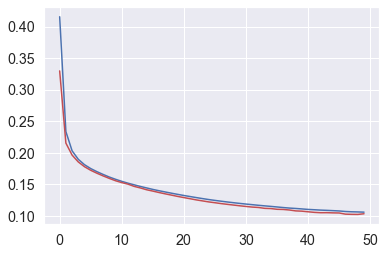

In [19]:
from turtle import color
history = ANN1.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [20]:
ANN2_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.107527,0.107527,0.105925,0.105925,0.105925,0.106566
MAE:,0.107527,0.107527,0.105925,0.105925,0.105925,0.106566
R^2:,-0.120482,-0.120482,-0.118474,-0.118474,-0.118474,-0.119277
roc_auc:,0.926439,0.942687,0.916752,0.920785,0.952165,0.931766
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.345867,0.313366,0.400458,0.373793,0.347314,0.356159


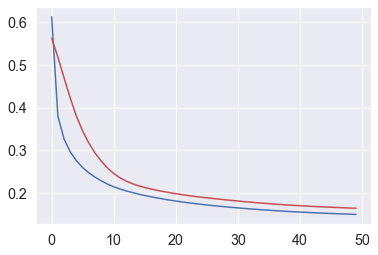

In [21]:
from turtle import color
history = ANN2.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [22]:
ANN3_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.011434,0.011434,0.011437,0.011437,0.011437,0.011436
MAE:,0.011434,0.011434,0.011437,0.011437,0.011437,0.011436
R^2:,-0.011566,-0.011566,-0.011570,-0.011570,-0.011570,-0.011568
roc_auc:,0.912143,0.893962,0.918285,0.885114,0.962464,0.914394
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.242658,0.226241,0.214563,0.245935,0.219753,0.229830


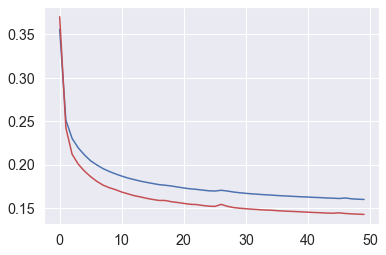

In [23]:
from turtle import color
history = ANN3.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [24]:
ANN4_metrics

,0,1,2,3,4,avg
Accuracy:,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
Precision:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MSE:,0.069159,0.069159,0.069159,0.069159,0.069159,0.069159
MAE:,0.069159,0.069159,0.069159,0.069159,0.069159,0.069159
R^2:,-0.074297,-0.074297,-0.074297,-0.074297,-0.074297,-0.074297
roc_auc:,0.935255,0.948252,0.941007,0.956936,0.969255,0.950141
F1:,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
logloss:,0.301638,0.275192,0.282770,0.297883,0.237991,0.279095


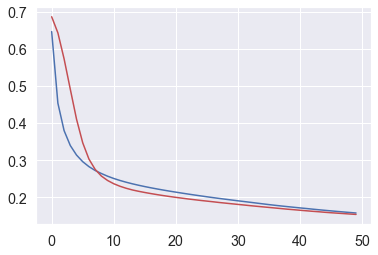

In [25]:
from turtle import color
history = ANN4.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

## Inference

In [26]:
def propensity_score_functANN(dataset,model,dataset2,dehwab):
    
    dataset2.columns = dataset2.columns.str.strip() 
    
    if dehwab == True: 
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re74','re75','re78']]
    else:
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re75','re78']]

    treat =  dataset.iloc[:,0]
    dataset =  dataset.iloc[:,1:len(dataset)]
    columns = dataset.columns
    dataset = dataset.to_numpy()
    dataset = dataset.astype(np.float32)
    #Y1 = np.reshape(Y1,(Y1.shape[0],1))
    # Generate propensity score prediction  
    probabilities = model.predict_proba(dataset)
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities # propensity score 
    # merge prediction and existing dataset 
    dataset = pd.DataFrame(dataset)
    dataset.columns = columns
    #dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba = pd.merge(dataset2, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={0:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [27]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_ANN = propensity_score_functANN(nswCps_lalonde_subset,ANN1,nswCps_lalonde,False)
nswPsid_lalonde_ps_ANN= propensity_score_functANN(nswPsid_lalonde_subset,ANN2,nswPsid_lalonde,False)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_ANN = propensity_score_functANN(nswCps_dehWab_subset,ANN3,nswCps_dehWab,True)
nswPsid_dehWab_ps_ANN = propensity_score_functANN(nswPsid_dehWab_subset,ANN4,nswPsid_dehWab,True)

In [31]:
nswPsid_lalonde_ps_ANN

,treat,age,education*,black,hispanic,married,nodegree,re75,re78,propensity_score,propensity_logit
0,1.0,37,11,1.0,0.0,1.0,1.0,0,9930,0.159121,-1.664782
1,1.0,22,9,0.0,1.0,0.0,1.0,0,3595,0.982575,4.032281
2,1.0,30,12,1.0,0.0,0.0,0.0,0,24909,0.120149,-1.991023
3,1.0,27,11,1.0,0.0,0.0,1.0,0,7506,0.018375,-3.978224
4,1.0,33,8,1.0,0.0,0.0,1.0,0,289,0.025632,-3.637934
...,...,...,...,...,...,...,...,...,...,...,...
2782,0.0,47,8,0.0,0.0,1.0,1.0,33837,38568,0.030807,-3.448728
2783,0.0,32,8,0.0,0.0,1.0,1.0,67137,59109,0.967974,3.408644
2784,0.0,47,10,0.0,0.0,1.0,1.0,47968,55710,0.061125,-2.731761
2785,0.0,54,0,0.0,1.0,1.0,1.0,44220,20540,0.160278,-1.656164


In [32]:
# save unmatched boost datasets 
nswCps_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswCps_lalonde_ps_unmatched_ANN_FS1.csv')
nswPsid_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswPsid_lalonde_ps_unmatched_ANN_FS1.csv')
nswCps_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswCps_dehWab_ps_unmatched_ANN_FS1.csv')
nswPsid_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/ann/unmatched/nswPsid_dehWab_ps_unmatched_ANN_FS1.csv')

## Bar plots of model performance

In [33]:
# Average accuracy
nsw_cps_lalonde_acc = [ANN1_metrics.loc['Accuracy:','avg'],boost1_metrics.loc['Accuracy:','avg'],forest1_metrics.loc['Accuracy:','avg'],cart1_metrics.loc['Accuracy:','avg'],logit1_metrics.loc['Accuracy:','avg']]
nsw_psid_lalonde_acc = [ANN2_metrics.loc['Accuracy:','avg'],boost2_metrics.loc['Accuracy:','avg'],forest2_metrics.loc['Accuracy:','avg'],cart2_metrics.loc['Accuracy:','avg'],logit2_metrics.loc['Accuracy:','avg']]
nsw_cps_dehWab_acc = [ANN3_metrics.loc['Accuracy:','avg'],boost3_metrics.loc['Accuracy:','avg'],forest3_metrics.loc['Accuracy:','avg'],cart3_metrics.loc['Accuracy:','avg'],logit3_metrics.loc['Accuracy:','avg']]
nsw_psid_dehWab_acc = [ANN4_metrics.loc['Accuracy:','avg'],boost4_metrics.loc['Accuracy:','avg'],forest4_metrics.loc['Accuracy:','avg'],cart4_metrics.loc['Accuracy:','avg'],logit4_metrics.loc['Accuracy:','avg']]

# Average precison
nsw_cps_lalonde_prec = [ANN1_metrics.loc['Precision:','avg'],boost1_metrics.loc['Precision:','avg'],forest1_metrics.loc['Precision:','avg'],cart1_metrics.loc['Precision:','avg'],logit1_metrics.loc['Precision:','avg']]
nsw_psid_lalonde_prec = [ANN2_metrics.loc['Precision:','avg'],boost2_metrics.loc['Precision:','avg'],forest2_metrics.loc['Precision:','avg'],cart2_metrics.loc['Precision:','avg'],logit2_metrics.loc['Precision:','avg']]
nsw_cps_dehWab_prec = [ANN3_metrics.loc['Precision:','avg'],boost3_metrics.loc['Precision:','avg'],forest3_metrics.loc['Precision:','avg'],cart3_metrics.loc['Precision:','avg'],logit3_metrics.loc['Precision:','avg']]
nsw_psid_dehWab_prec = [ANN4_metrics.loc['Precision:','avg'],boost4_metrics.loc['Precision:','avg'],forest4_metrics.loc['Precision:','avg'],cart4_metrics.loc['Precision:','avg'],logit4_metrics.loc['Precision:','avg']]

# Average recall 
nsw_cps_lalonde_rec = [ANN1_metrics.loc['Recall:','avg'],boost1_metrics.loc['Recall:','avg'],forest1_metrics.loc['Recall:','avg'],cart1_metrics.loc['Recall:','avg'],logit1_metrics.loc['Recall:','avg']]
nsw_psid_lalonde_rec = [ANN2_metrics.loc['Recall:','avg'],boost2_metrics.loc['Recall:','avg'],forest2_metrics.loc['Recall:','avg'],cart2_metrics.loc['Recall:','avg'],logit2_metrics.loc['Recall:','avg']]
nsw_cps_dehWab_rec = [ANN3_metrics.loc['Recall:','avg'],boost3_metrics.loc['Recall:','avg'],forest3_metrics.loc['Recall:','avg'],cart3_metrics.loc['Recall:','avg'],logit3_metrics.loc['Recall:','avg']]
nsw_psid_dehWab_rec = [ANN4_metrics.loc['Recall:','avg'],boost4_metrics.loc['Recall:','avg'],forest4_metrics.loc['Recall:','avg'],cart4_metrics.loc['Recall:','avg'],logit4_metrics.loc['Recall:','avg']]

# Average F1 
nsw_cps_lalonde_f1 = [ANN1_metrics.loc['F1:','avg'],boost1_metrics.loc['F1:','avg'],forest1_metrics.loc['F1:','avg'],cart1_metrics.loc['F1:','avg'],logit1_metrics.loc['F1:','avg']]
nsw_psid_lalonde_f1 = [ANN2_metrics.loc['F1:','avg'],boost2_metrics.loc['F1:','avg'],forest2_metrics.loc['F1:','avg'],cart2_metrics.loc['F1:','avg'],logit2_metrics.loc['F1:','avg']]
nsw_cps_dehWab_f1 = [ANN3_metrics.loc['F1:','avg'],boost3_metrics.loc['F1:','avg'],forest3_metrics.loc['F1:','avg'],cart3_metrics.loc['F1:','avg'],logit3_metrics.loc['F1:','avg']]
nsw_psid_dehWab_f1 = [ANN4_metrics.loc['F1:','avg'],boost4_metrics.loc['F1:','avg'],forest4_metrics.loc['F1:','avg'],cart4_metrics.loc['F1:','avg'],logit4_metrics.loc['F1:','avg']]

# Average log loss
nsw_cps_lalonde_logloss = [ANN1_metrics.loc['logloss:','avg'],boost1_metrics.loc['log-loss:','avg'],forest1_metrics.loc['log-loss:','avg'],cart1_metrics.loc['log-loss:','avg'],logit1_metrics.loc['log-loss:','avg']]
nsw_psid_lalonde_logloss = [ANN2_metrics.loc['logloss:','avg'],boost2_metrics.loc['log-loss:','avg'],forest2_metrics.loc['log-loss:','avg'],cart2_metrics.loc['log-loss:','avg'],logit2_metrics.loc['log-loss:','avg']]
nsw_cps_dehWab_logloss = [ANN3_metrics.loc['logloss:','avg'],boost3_metrics.loc['log-loss:','avg'],forest3_metrics.loc['log-loss:','avg'],cart3_metrics.loc['log-loss:','avg'],logit3_metrics.loc['log-loss:','avg']]
nsw_psid_dehWab_logloss = [ANN4_metrics.loc['logloss:','avg'],boost4_metrics.loc['log-loss:','avg'],forest4_metrics.loc['log-loss:','avg'],cart4_metrics.loc['log-loss:','avg'],logit4_metrics.loc['log-loss:','avg']]

# Average Roc Auc 
nsw_cps_lalonde_rocauc = [ANN1_metrics.loc['roc_auc:','avg'],boost1_metrics.loc['roc_auc:','avg'],forest1_metrics.loc['roc_auc:','avg'],cart1_metrics.loc['roc_auc:','avg'],logit1_metrics.loc['roc_auc:','avg']]
nsw_psid_lalonde_rocauc = [ANN2_metrics.loc['roc_auc:','avg'],boost2_metrics.loc['roc_auc:','avg'],forest2_metrics.loc['roc_auc:','avg'],cart2_metrics.loc['roc_auc:','avg'],logit2_metrics.loc['roc_auc:','avg']]
nsw_cps_dehWab_rocauc = [ANN3_metrics.loc['roc_auc:','avg'],boost3_metrics.loc['roc_auc:','avg'],forest3_metrics.loc['roc_auc:','avg'],cart3_metrics.loc['roc_auc:','avg'],logit3_metrics.loc['roc_auc:','avg']]
nsw_psid_dehWab_rocauc = [ANN4_metrics.loc['roc_auc:','avg'],boost4_metrics.loc['roc_auc:','avg'],forest4_metrics.loc['roc_auc:','avg'],cart4_metrics.loc['roc_auc:','avg'],logit4_metrics.loc['roc_auc:','avg']]

NameError: name 'boost1_metrics' is not defined

NameError: name 'bundles' is not defined

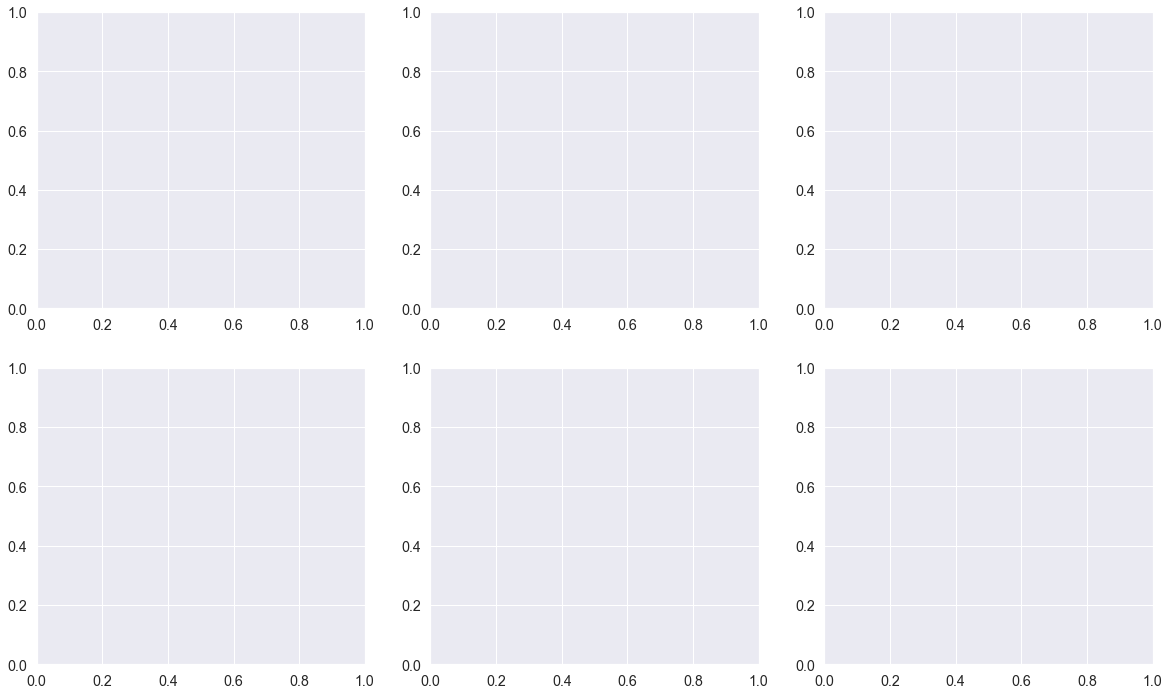

In [34]:
# Create plot 
# Update plot paramaters 
fig, ax = plt.subplots(nrows=2, ncols=3,figsize = (20,12))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 300}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=2, ncols=3))
plt.rcParams.update({'font.size': 18})
y = np.arange(5)
x = np.arange(1)
width = 0.2
# Balanced accuracy

ax[0,0].set_title("Balanced accuracy",fontsize=20)
ax[0,0].set_xlabel('score',fontsize=16)
ax[0,0].set_yticks(y+2*width, ['neural network', 'boosted tree', 'random forest', 'cart', 'logistic regression'],fontsize=16)
ax[0,0].tick_params(axis='x', which='major', labelsize=16)

colour1 = "#E31B23" # CPS lalonde
colour2 = "#e31b8c" # PSID lalonde
colour3 = "#003366" # CPS dehwab
colour4 = "#006614" # PSID dehwab

ax[0,0].barh(y,nsw_cps_lalonde_acc,width,color = colour1)
ax[0,0].barh(y+width,nsw_psid_lalonde_acc,width,color = colour2)
ax[0,0].barh(y+2*width,nsw_cps_dehWab_acc,width,color = colour3)
ax[0,0].barh(y+(3*width),nsw_psid_dehWab_acc,width,color = colour4)

ax[0,0].set_facecolor('white')
ax[0,0].grid(color='white', axis='y')
ax[0,0].grid(color='white', axis='x')
ax[0,0].spines['left']
ax[0,0].spines['right']
ax[0,0].spines['bottom']
ax[0,0].tick_params(right='on')
ax[0,0].tick_params(left='on')
ax[0,0].tick_params(bottom='on')

# precision

ax[0,1].set_title("precision",fontsize=20)
ax[0,1].set_xlabel('score',fontsize=16)
ax[0,1].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[0,1].tick_params(axis='x', which='major', labelsize=16)

ax[0,1].barh(y,nsw_cps_lalonde_prec,width,color = colour1)
ax[0,1].barh(y+width,nsw_psid_lalonde_prec,width,color = colour2)
ax[0,1].barh(y+2*width,nsw_cps_dehWab_prec,width,color = colour3)
ax[0,1].barh(y+(3*width),nsw_psid_dehWab_prec,width,color = colour4)

ax[0,1].set_facecolor('white')
ax[0,1].grid(color='white', axis='y')
ax[0,1].grid(color='white', axis='x')
ax[0,1].spines['left']
ax[0,1].spines['right']
ax[0,1].spines['bottom']
ax[0,1].tick_params(right='on')
ax[0,1].tick_params(left='on')
ax[0,1].tick_params(bottom='on')

# recall 

ax[0,2].set_title("Recall",fontsize=20)
ax[0,2].set_xlabel('score',fontsize=16)
ax[0,2].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[0,2].tick_params(axis='x', which='major', labelsize=16)

ax[0,2].barh(y,nsw_cps_lalonde_rec,width,color = colour1)
ax[0,2].barh(y+width,nsw_psid_lalonde_rec,width,color = colour2)
ax[0,2].barh(y+2*width,nsw_cps_dehWab_rec,width,color = colour3)
ax[0,2].barh(y+(3*width),nsw_psid_dehWab_rec,width,color = colour4)

ax[0,2].set_facecolor('white')
ax[0,2].grid(color='white', axis='y')
ax[0,2].grid(color='white', axis='x')
ax[0,2].spines['left']
ax[0,2].spines['right']
ax[0,2].spines['bottom']
ax[0,2].tick_params(right='on')
ax[0,2].tick_params(left='on')
ax[0,2].tick_params(bottom='on')

# F1
ax[1,0].set_title("F1 score",fontsize=20)
ax[1,0].set_xlabel('score',fontsize=16)
ax[1,0].set_yticks(y+2*width, ['neural network', 'boosted tree', 'random forest', 'cart', 'logistic regression'],fontsize=16)
ax[1,0].tick_params(axis='x', which='major', labelsize=16)

ax[1,0].barh(y,nsw_cps_lalonde_f1,width,color = colour1)
ax[1,0].barh(y+width,nsw_psid_lalonde_f1,width,color = colour2)
ax[1,0].barh(y+2*width,nsw_cps_dehWab_f1,width,color = colour3)
ax[1,0].barh(y+(3*width),nsw_psid_dehWab_f1,width,color = colour4)

ax[1,0].set_facecolor('white')
ax[1,0].grid(color='white', axis='y')
ax[1,0].grid(color='white', axis='x')
ax[1,0].spines['left']
ax[1,0].spines['right']
ax[1,0].spines['bottom']
ax[1,0].tick_params(right='on')
ax[1,0].tick_params(left='on')
ax[1,0].tick_params(bottom='on')


# Log loss
ax[1,1].set_title("Log loss",fontsize=20)
ax[1,1].set_xlabel('score',fontsize=16)
ax[1,1].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[1,1].tick_params(axis='x', which='major', labelsize=16)

ax[1,1].barh(y,nsw_cps_lalonde_logloss,width,color = colour1)
ax[1,1].barh(y+width,nsw_psid_lalonde_logloss,width,color = colour2)
ax[1,1].barh(y+2*width,nsw_cps_dehWab_logloss,width,color = colour3)
ax[1,1].barh(y+(3*width),nsw_psid_dehWab_logloss,width,color = colour4)

ax[1,1].set_facecolor('white')
ax[1,1].grid(color='white', axis='y')
ax[1,1].grid(color='white', axis='x')
ax[1,1].spines['left']
ax[1,1].spines['right']
ax[1,1].spines['bottom']
ax[1,1].tick_params(right='on')
ax[1,1].tick_params(left='on')
ax[1,1].tick_params(bottom='on')

# Roc-AUC
ax[1,2].set_title("Roc-Auc",fontsize=20)
ax[1,2].set_xlabel('score',fontsize=16)
ax[1,2].set_yticks(y+2*width, [' ', ' ', ' ', ' ', ' '],fontsize=16)
ax[1,2].tick_params(axis='x', which='major', labelsize=16)

ax[1,2].barh(y,nsw_cps_lalonde_rocauc,width,color = colour1)
ax[1,2].barh(y+width,nsw_psid_lalonde_rocauc,width,color = colour2)
ax[1,2].barh(y+2*width,nsw_cps_dehWab_rocauc,width,color = colour3)
ax[1,2].barh(y+(3*width),nsw_psid_dehWab_rocauc,width,color = colour4)

ax[1,2].set_facecolor('white')
ax[1,2].grid(color='white', axis='y')
ax[1,2].grid(color='white', axis='x')
ax[1,2].spines['left']
ax[1,2].spines['right']
ax[1,2].spines['bottom']
ax[1,2].tick_params(right='on')
ax[1,2].tick_params(left='on')
ax[1,2].tick_params(bottom='on')

labels = ['CPS - Lalonde','PSID - Lalonde','CPS - DW','PSID - DW']
fig.legend(labels, loc='lower center', bbox_to_anchor=(0.5,-0.1), ncol=len(labels),markerscale=3, bbox_transform=fig.transFigure,prop={'size': 18})

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig8_training_evaluation_averages.png', bbox_inches='tight')
plt.show()

### Analysis on model outptus - Probability calibration curves 

In [ ]:
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/data/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

In [ ]:
from sklearn import tree      
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier    


# Take a random sample from the data with an even number of treated and control for testing

nswCps_lalonde_valid = nswCps_lalonde.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswCps_lalonde = nswCps_lalonde.drop(nswCps_lalonde_valid.index) # Remove all samples from training which are in the sample 

nswPsid_lalonde_valid = nswPsid_lalonde.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswPsid_lalonde = nswPsid_lalonde.drop(nswPsid_lalonde_valid.index) # Remove all samples from training which are in the sample 

nswCps_dehWab_valid = nswCps_dehWab.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswCps_dehWab = nswCps_dehWab.drop(nswCps_dehWab_valid.index)# Remove all samples from training which are in the sample 

nswPsid_Dehwab_valid = nswPsid_dehWab.groupby('treat',group_keys=False).apply(lambda x: x.sample(50))
nswPsid_dehWab = nswPsid_dehWab.drop(nswPsid_Dehwab_valid.index) # Remove all samples from training which are in the sample 

# covariates used in each mdoel 
logit_vars = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','re75','u75','educ_re75']
logit_vars2 = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','re74','re75','u74','u75','educ_re75']
tree_vars = ['treat','age','education*','black','hispanic','married','nodegree','re75']
tree_vars2 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75']
ann_vars = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 'education_13','education_14', 'education_15', 'education_16', 'education_17']
ann_vars2 = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre74','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12',  'education_13', 'education_14', 'education_15', 'education_16', 'education_17']
continuos_vars = ['ageboxcox','lnre75'] 
continuos_vars2= ['ageboxcox','lnre74','lnre75'] 
# ======== Lalonde - sample ======== #

# ~~~~~~~~~~
# 1 cps
# ~~~~~~~~~~

#logit model 
cps_lalonde_subset_logit = nswCps_lalonde[logit_vars]
cps_lalonde_subset_valid_logit = nswCps_lalonde_valid[logit_vars]
#decision tree models 
cps_lalonde_subset_trees = nswCps_lalonde[tree_vars]
cps_lalonde_subset_valid_trees = nswCps_lalonde_valid[tree_vars]
#ann model 
cps_lalonde_subset_ann = nswCps_lalonde[ann_vars]
cps_lalonde_subset_valid_ann = nswCps_lalonde_valid[ann_vars]
cps_lalonde_subset_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_ann[continuos_vars])
cps_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_lalonde_subset_valid_ann[continuos_vars])

# ~~~~~~~~~~
# 2 PSID 
# ~~~~~~~~~~

#logit model 
psid_lalonde_subset_logit = nswPsid_lalonde[logit_vars]
psid_lalonde_subset_valid_logit = nswPsid_lalonde_valid[logit_vars]
#decision tree models 
psid_lalonde_subset_trees = nswPsid_lalonde[tree_vars]
psid_lalonde_subset_valid_trees = nswPsid_lalonde_valid[tree_vars]
#ann model 
psid_lalonde_subset_ann = nswPsid_lalonde[ann_vars]
psid_lalonde_subset_valid_ann = nswPsid_lalonde_valid[ann_vars]
psid_lalonde_subset_ann[continuos_vars] = sc.fit_transform(psid_lalonde_subset_ann[continuos_vars])
psid_lalonde_subset_valid_ann[continuos_vars] = sc.fit_transform(psid_lalonde_subset_valid_ann[continuos_vars])


# ======== Dehejia - Wahba sample ======== #

# ~~~~~~~~~~
# 3 CPS
# ~~~~~~~~~~
# logit 
cps_dehWab_subset_logit = nswCps_dehWab[logit_vars2]
cps_dehWab_subset_valid_logit = nswCps_dehWab_valid[logit_vars2]
# decision tree's
cps_dehWab_subset_trees = nswCps_dehWab[tree_vars2]
cps_dehWab_subset_valid_trees = nswCps_dehWab_valid[tree_vars2]
#ann
cps_dehWab_subset_ann = nswCps_dehWab[ann_vars2]
cps_dehWab_subset_valid_ann = nswCps_dehWab_valid[ann_vars2]
cps_dehWab_subset_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_ann[continuos_vars])
cps_dehWab_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_valid_ann[continuos_vars])

# ~~~~~~~~~~
# 4 PSID
# ~~~~~~~~~~
# logit 
psid_dehWab_subset_logit = nswCps_dehWab[logit_vars2]
psid_dehWab_subset_valid_logit = nswCps_dehWab_valid[logit_vars2]
# decision tree's
psid_dehWab_subset_trees = nswCps_dehWab[tree_vars2]
psid_dehWab_subset_valid_trees = nswCps_dehWab_valid[tree_vars2]
#ann
psid_dehWab_subset_ann = nswCps_dehWab[ann_vars2]
psid_dehWab_subset_valid_ann = nswCps_dehWab_valid[ann_vars2]
psid_dehWab_subset_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_ann[continuos_vars])
psid_dehWab_subset_valid_ann[continuos_vars] = sc.fit_transform(cps_dehWab_subset_valid_ann[continuos_vars])

# Function to run all models and get a prediction - using the best features from our grid search 
# Inputs are the dataset's we want to look at 


def fit_and_predict_all_models(logit_data,logit_valid,tree_data,tree_valid,ann_data,ann_valid,neuralnet):
    
    '''
    could make this function do all the smote and rejoing the validation set again sincce i am making my own, so there are more training examples
    
    '''
   
  
    
    #Train test split 
    def return_trainTest_split(Dataset):
        # shuffle data
        Dataset = Dataset.sample(frac = 1,random_state=0)
        Features = Dataset.drop('treat', axis=1)
        Target = Dataset['treat']
        X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size=0.3, shuffle=True)
        return X_train, X_test, y_train, y_test;

    
    resample=SMOTEENN(random_state=0) # resampling
    
    '''
    '''
    
    # Logit
    
    X_train1, X_test1, y_train1, y_test1 = return_trainTest_split(logit_data)
    X_train1, y_train1 = resample.fit_resample(X_train1, y_train1)	
    
    shuffled = pd.concat([pd.DataFrame(X_train1),pd.DataFrame(y_train1)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train1, y_train1 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
    
    logit_demo = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
    
    logit_demo.fit(X_train1,y_train1)
    
    logit_valid = logit_valid.sample(frac = 1,random_state=0)
    X_test1 = logit_valid.drop('treat',axis=1, inplace = False)
    y_test1 = logit_valid['treat']
    
    predicted_proba_logit = logit_demo.predict_proba(X_test1)
    
    
    
    # Decision tree models 
    
    X_train2, X_test2, y_train2, y_test2 = return_trainTest_split(tree_data)

    X_train2, y_train2 = resample.fit_resample(X_train2, y_train2)	
    shuffled = pd.concat([pd.DataFrame(X_train2),pd.DataFrame(y_train2)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train2, y_train2 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]

    tree_valid = tree_valid.sample(frac = 1,random_state=0)
    X_test2 = tree_valid.drop('treat',axis=1, inplace = False)
    y_test2 = tree_valid['treat']

    # Cart
    
    CART_demo = tree.DecisionTreeClassifier(random_state=0,criterion = 'entropy',max_depth = 5, max_leaf_nodes=12,min_samples_leaf=2)
    CART_demo.fit(X_train2,y_train2)
    predicted_proba_cart = CART_demo.predict_proba(X_test2)
    #RF
    forest_demo = RandomForestClassifier(random_state=0,criterion='entropy',max_depth=8,max_features='auto',min_samples_split=3,n_estimators=500)
    forest_demo.fit(X_train2,y_train2)
    predicted_proba_forest = forest_demo.predict_proba(X_test2)
    #boost
    boost_demo = XGBClassifier(objective= 'binary:logistic',booser='dart',colsample_bytree=0.3,gamma=0.5,learning_rate=0.05,mind_child_weight=1,subsample=0.5,seed=0,nthread=4)  
    boost_demo.fit(X_train2,y_train2)
    predicted_proba_boost = boost_demo.predict_proba(X_test2)

    #ANN
    X_train3, X_test3, y_train3, y_test3 = return_trainTest_split(ann_data)
    X_train3, y_train3 = resample.fit_resample(X_train3, y_train3)	
    shuffled = pd.concat([pd.DataFrame(X_train3),pd.DataFrame(y_train3)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
    X_train3, y_train3 = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]

    ann_valid = ann_valid.sample(frac = 1,random_state=0)
    X_test3 = ann_valid.drop('treat',axis=1, inplace = False)
    y_test3 = ann_valid['treat']

    Epochs = 100
    learning_rate = 0.0001
    weight_decay = 0.05
    batch_size = 256

    X_train3 = X_train3.to_numpy()
    y_train3 = y_train3.to_numpy()
    X_train3 = X_train3.astype(np.float32)
    y_train3 = y_train3.astype(np.float32)
    y_train3 = np.reshape(y_train3,(y_train3.shape[0],1))

    X_test3 = X_test3.to_numpy()
    y_test3 = y_test3.to_numpy()
    X_test3 = X_test3.astype(np.float32)
    y_test3 = y_test3.astype(np.float32)
    y_test3 = np.reshape(y_test3,(y_test3.shape[0],1))

    ann_demo = NeuralNetClassifier(neuralnet,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size =batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False,verbose=0 )

    ann_demo.fit(X_train3,y_train3)
    predicted_proba_ANN = ann_demo.predict_proba(X_test3)
    
    return predicted_proba_logit,predicted_proba_cart,predicted_proba_forest,predicted_proba_boost,predicted_proba_ANN,y_test1,y_test2,y_test3;

    
    

logit_proba1,cart_proba1,forest_proba1,boost_proba1,ann_proba1,yl1,yt1,ya1 = fit_and_predict_all_models(cps_lalonde_subset_logit,
                                                                                            cps_lalonde_subset_valid_logit,
                                                                                            cps_lalonde_subset_trees,
                                                                                            cps_lalonde_subset_valid_trees,
                                                                                            cps_lalonde_subset_ann,
                                                                                            cps_lalonde_subset_valid_ann,
                                                                                            twoLayerNN1)

logit_proba2,cart_proba2,forest_proba2,boost_proba2,ann_proba2,yl2,yt2,ya2 = fit_and_predict_all_models(psid_lalonde_subset_logit,
                                                                                            psid_lalonde_subset_valid_logit,
                                                                                            psid_lalonde_subset_trees,
                                                                                            psid_lalonde_subset_valid_trees,
                                                                                            psid_lalonde_subset_ann,
                                                                                            psid_lalonde_subset_valid_ann,
                                                                                            twoLayerNN1)

logit_proba3,cart_proba3,forest_proba3,boost_proba3,ann_proba3,yl3,yt3,ya3 = fit_and_predict_all_models(cps_dehWab_subset_logit,
                                                                                            cps_dehWab_subset_valid_logit,
                                                                                            cps_dehWab_subset_trees,
                                                                                            cps_dehWab_subset_valid_trees,
                                                                                            cps_dehWab_subset_ann,
                                                                                            cps_dehWab_subset_valid_ann,
                                                                                            twoLayerNN2)

logit_proba4,cart_proba4,forest_proba4,boost_proba4,ann_proba4,yl4,yt4,ya4 = fit_and_predict_all_models(psid_dehWab_subset_logit,
                                                                                            psid_dehWab_subset_valid_logit,
                                                                                            psid_dehWab_subset_trees,
                                                                                            psid_dehWab_subset_valid_trees,
                                                                                            psid_dehWab_subset_ann,
                                                                                            psid_dehWab_subset_valid_ann,
                                                                                            twoLayerNN2)

# Calibration curve for each models prediction 
from sklearn.calibration import calibration_curve
logit_fop1  , logit_mpv1  = calibration_curve(yl1, logit_proba1[:,1], n_bins=10, normalize=True)
cart_fop1   , cart_mpv1   = calibration_curve(yt1, cart_proba1[:,1], n_bins=10, normalize=True)
forest_fop1  , forest_mpv1 = calibration_curve(yt1, forest_proba1[:,1], n_bins=10, normalize=True)
boost_fop1  , boost_mpv1  = calibration_curve(yt1, boost_proba1[:,1], n_bins=10, normalize=True)
ann_fop1    , ann_mpv1    = calibration_curve(ya1, ann_proba1, n_bins=10, normalize=True)

logit_fop2  , logit_mpv2  = calibration_curve(yl2, logit_proba2[:,1], n_bins=10, normalize=True)
cart_fop2   , cart_mpv2   = calibration_curve(yt2, cart_proba2[:,1], n_bins=10, normalize=True)
forest_fop2  , forest_mpv2 = calibration_curve(yt2, forest_proba2[:,1], n_bins=10, normalize=True)
boost_fop2  , boost_mpv2  = calibration_curve(yt2, boost_proba2[:,1], n_bins=10, normalize=True)
ann_fop2    , ann_mpv2    = calibration_curve(ya2, ann_proba2, n_bins=10, normalize=True)

logit_fop3  , logit_mpv3  = calibration_curve(yl3, logit_proba3[:,1], n_bins=10, normalize=True)
cart_fop3   , cart_mpv3   = calibration_curve(yt3, cart_proba3[:,1], n_bins=10, normalize=True)
forest_fop3  , forest_mpv3 = calibration_curve(yt3, forest_proba3[:,1], n_bins=10, normalize=True)
boost_fop3  , boost_mpv3  = calibration_curve(yt3, boost_proba3[:,1], n_bins=10, normalize=True)
ann_fop3    , ann_mpv3    = calibration_curve(ya3, ann_proba3, n_bins=10, normalize=True)

logit_fop4  , logit_mpv4  = calibration_curve(yl4, logit_proba4[:,1], n_bins=10, normalize=True)
cart_fop4   , cart_mpv4   = calibration_curve(yt4, cart_proba4[:,1], n_bins=10, normalize=True)
forest_fop4  , forest_mpv4 = calibration_curve(yt4, forest_proba4[:,1], n_bins=10, normalize=True)
boost_fop4  , boost_mpv4  = calibration_curve(yt4, boost_proba4[:,1], n_bins=10, normalize=True)
ann_fop4    , ann_mpv4    = calibration_curve(ya4, ann_proba4, n_bins=10, normalize=True)


import scipy.stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes

fig, ax = plt.subplots(nrows=2, ncols=2,figsize = (8,6))

plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(axes.lines())


ax[0,0].grid(color='white', axis='x')
ax[0,0].grid(color='white', axis='y')
ax[0,1].grid(color='white', axis='x')
ax[0,1].grid(color='white', axis='y')
ax[1,0].grid(color='white', axis='x')
ax[1,0].grid(color='white', axis='y')
ax[1,1].grid(color='white', axis='x')
ax[1,1].grid(color='white', axis='y')


marker = 's'
linewidth = 1
marker_size = 3

ax[0,0].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[0,0].plot(logit_mpv1  , logit_fop1 , marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(cart_mpv1   , cart_fop1, marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(forest_mpv1 , forest_fop1,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(boost_mpv1  , boost_fop1,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[0,0].plot(ann_mpv1    , ann_fop1 ,marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[0,0].set_xlabel('Mean predicted value')
ax[0,0].set_ylabel('Fraction of positives')

ax[0,1].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[0,1].plot(logit_mpv2  , logit_fop2 , marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(cart_mpv2   , cart_fop2  , marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(forest_mpv2 , forest_fop2 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(boost_mpv2  , boost_fop2  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[0,1].plot(ann_mpv2    , ann_fop2    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[0,1].set_xlabel('Mean predicted value')
ax[0,1].set_ylabel('Fraction of positives')

ax[1,0].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=1,color='black')
ax[1,0].plot(logit_mpv3  , logit_fop3  ,marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(cart_mpv3   , cart_fop3   ,marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(forest_mpv3 , forest_fop3 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(boost_mpv3  , boost_fop3  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[1,0].plot(ann_mpv3    , ann_fop3    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[1,0].set_xlabel('Mean predicted value')
ax[1,0].set_ylabel('Fraction of positives')

ax[1,1].plot([0, 1], [0, 1], linestyle='dotted', label='perfectly calibrated',linewidth=linewidth,color='black')
ax[1,1].plot(logit_mpv4  , logit_fop4  ,marker = marker , label='Logit ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(cart_mpv4   , cart_fop4   ,marker  = marker  ,label='cart ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(forest_mpv4 , forest_fop4 ,marker = marker  , label='forest ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(boost_mpv4  , boost_fop4  ,marker = marker  , label='boost ',linewidth=linewidth,markersize=marker_size)
ax[1,1].plot(ann_mpv4    , ann_fop4    , marker = marker , label='ANN ',linewidth=linewidth,markersize=marker_size)
ax[1,1].set_xlabel('Mean predicted value')
ax[1,1].set_ylabel('Fraction of positives')


plt.legend(loc=(1.04, 0.1))
plt.show()

## Box plots

# Box plots of estimated propensity scores across each model - CPS group 

fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022())
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}


treated_propensity_PS = logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1]

Logit_Cpscomprison_PS = logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0]
Logit_Psidcomprison_PS = logitNswPsid_lalonde['propensity_score'][logitNswPsid_lalonde['treat']==0]

cart_Cpscomprison_PS = cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0]
cart_Psidcomprison_PS = cartNswPsid_lalonde['propensity_score'][cartNswPsid_lalonde['treat']==0]

ax.boxplot([treated_propensity_PS,Logit_Cpscomprison_PS,Logit_Psidcomprison_PS,cart_Cpscomprison_PS,cart_Psidcomprison_PS],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5],['Treated', 'Logit cps ','Logit psid','Cart  cps','Cart psid'])


ax.set_xlabel('Model')

ax.set_ylabel('Propensity score')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/_boxplots.png', bbox_inches='tight')

plt.show()